In [9]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import math
from scipy import signal
from scipy.ndimage import gaussian_filter
import scipy.signal

In [3]:
# Compute partial derivative given a kernel
def compute_partial_derivative(I, kernel):    
    return signal.convolve2d(I, kernel, boundary="symm", mode="same") 

# Compute components of Q (see formula assignment)
def compute_Q_components(I_x, I_y):
    # As a rule of thumb the kernel size has to be about 3 times sigma
    # gaussian_filter automatically generates a kernel with a radius of int(truncate * sigma + 0.5) 
    # We want a kernel size 3 since G_d is size 3, so we set sigma to 1
    A = gaussian_filter(I_x ** 2, 1)
    B = gaussian_filter(I_x * I_y, 1)
    C = gaussian_filter(I_y ** 2, 1)

    n = A.shape[0] + B.shape[0]
    m = A.shape[1] + B.shape[1]

    Q = np.array([[A, B],
                [B, C]]).reshape((n, m))

    # Covariance matrix of Q such that it is square
    Q_cov = np.matmul(Q, Q.T)

    #print(LA.eigh(Q_cov))    

    return A, B, C

# Compute H (see formula assignment)
def compute_H(A, B, C):
    H = ((A * C) - (B ** 2)) - 0.04 * ((A + C) ** 2)
    return H

# Detect corners using Harrison Corner algorithm
def detect_corners(H, n, T, surpress = False):
    """
        H:          H image, i.e. raw corner response
        n:          specified window size nxn around a centered pixel located in H    
        T:          user defined threshold
        surpress:   when centered pixel located in H is not peak value surpress it (lowering the value) 
                    or retain it by default by default setting it to False  
    """
    # H = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
    #             [8, 8, 8, 8, 8, 8, 8, 8, 8],
    #             [5, 5, 5, 5, 5, 5, 5, 5, 5],
    #             [3, 3, 3, 3, 3, 3, 3, 3, 3]])

    # Handle borders by filling up neighbours out of bounds with zeros
    padding = int((n - 1) / 2)

    # Add vertical padding
    row = np.zeros((padding, H.shape[1]))
    H_pad = np.vstack((row, H, row))

    # Add horizontal padding
    col = np.zeros((H_pad.shape[0], padding))
    H_pad = np.hstack((col, H_pad, col))

    rows, cols = H_pad.shape

    # Indices of corner point
    r = np.empty(0)
    c = np.empty(0)

    # Find local maxima
    for x_i in range(padding, cols - padding):
        for y_i in range(padding, rows - padding):
            # Get neighbourhood patch
            patch = H_pad[y_i - padding : y_i + padding + 1, x_i - padding : x_i + padding + 1]
            patch_flat = patch.flatten()

            # Center point of patch
            center_i = int(patch.size / 2)
            center_val = patch_flat[center_i]

            # Center point's neighbours 
            patch_neighbours = np.delete(patch_flat, center_i)

            # If center value is greater than all its neighbours (in an n × n window centered around this point) 
            # and (2) if it is greater than the user-defined threshold T: mark it as a corner point and retain it
            if all(val < center_val for val in patch_neighbours) and center_val > T:
                r = np.append(r, y_i - padding)
                c = np.append(c, x_i - padding)
            # Surpress it   
            else:
                if surpress:
                    H_pad[y_i][x_i] = 0

    return r, c

# Show distribution of I_x and I_y

In [5]:
def estimate_optical_flow(patch1, patch2, size):
    Gx = np.array([[-1, 0 ,1]])
    Gy = Gx.T
    A = np.zeros((patch1.size, 2))
    Ix = scipy.signal.convolve2d(patch1, Gx, boundary="symm", mode="same")
    Iy = scipy.signal.convolve2d(patch1, Gy, boundary="symm", mode="same")
    A[:,0] = np.array(Ix.reshape(-1))
    A[:,1] = np.array(Iy.reshape(-1))
    It = patch1 - patch2
    b = -1 * It.reshape(size * size, 1)
#     Gt = np.array([[-1, 1]])
#     b = -scipy.signal.convolve2d(np.vstack((np.ravel(patch1), np.ravel(patch2))).T, Gt, mode="valid")
    A_pinv = np.linalg.pinv(A)
    [vx, vy] = np.matmul(A_pinv, b)
    
    return [vx, vy]

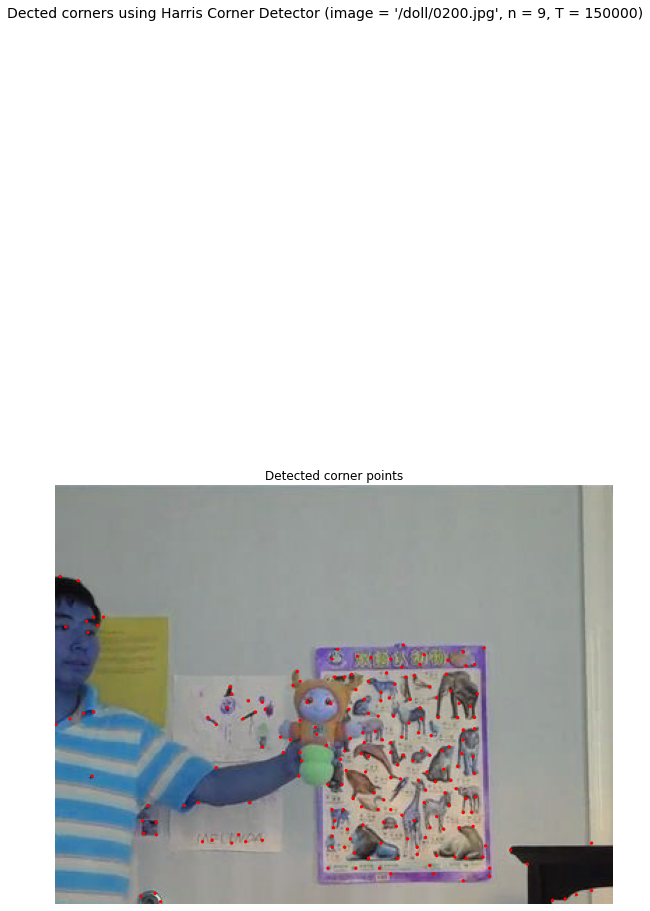

300
1  =  0200.jpg
175
4
171 : 180
[[  0.   0.   0.   0.  88.  94. 100.  96.  82.]
 [  0.   0.   0.   0.  90.  89.  84.  78.  78.]
 [  0.   0.   0.   0.  90.  81.  77.  89. 112.]
 [  0.   0.   0.   0.  71.  81.  98. 116. 129.]
 [  0.   0.   0.   0.  73.  98. 126. 137. 130.]
 [  0.   0.   0.   0. 111. 120. 131. 136. 135.]
 [  0.   0.   0.   0. 132. 131. 129. 129. 130.]
 [  0.   0.   0.   0. 130. 134. 135. 131. 126.]
 [  0.   0.   0.   0. 136. 137. 137. 135. 134.]]
x =  0.0 , y =  171.0
vx =  0.003785033841860921 , vy =  -0.01739733825184664
x_new =  0.03785033841860921 , y_new =  170.82602661748155


69
7
65 : 74
[[  0. 138. 138. 139. 139. 140. 140. 141. 141.]
 [  0. 138. 138. 138. 139. 140. 140. 140. 141.]
 [  0. 138. 138. 138. 139. 139. 140. 140. 141.]
 [  0. 142. 150. 140. 125. 133. 145. 142. 133.]
 [  0. 103. 102.  85.  74.  92. 117. 129. 133.]
 [  0.  36.  34.  23.  21.  39.  55.  61.  67.]
 [  0.  15.  17.  13.  16.  23.  20.  15.  19.]
 [  0.  22.  23.  19.  17.  19.  14.  14.  2

vx =  -0.4479170652931563 , vy =  -0.36798612367108374
x_new =  192.52082934706843 , y_new =  152.32013876328915


128
202
124 : 133
[[118. 119. 128. 150. 106. 147.  74. 172. 125.]
 [124. 119. 161. 159.  92. 127.  92. 162. 139.]
 [116. 122. 145.  94.  69. 140. 134. 145. 141.]
 [123. 135. 118.  60.  99. 169. 160. 149. 153.]
 [122. 122. 122. 102. 140. 162. 147. 155. 162.]
 [110. 107. 134. 120. 127. 162. 156. 153. 157.]
 [126. 129. 129. 107. 101. 154. 159. 143. 144.]
 [147. 145. 103. 101.  88.  95. 101. 113. 116.]
 [133. 138. 137. 125. 110. 101. 104. 107. 101.]]
x =  198.0 , y =  124.0
vx =  0.30236555521434105 , vy =  -0.17468720712606672
x_new =  201.02365555214342 , y_new =  122.25312792873933


236
202
232 : 241
[[165. 163. 165. 164. 157. 148. 155. 148. 152.]
 [173. 176. 180. 180. 173. 165. 160. 157. 163.]
 [170. 173. 167. 157. 161. 173. 157. 157. 163.]
 [175. 179. 160. 132. 137. 163. 167. 162. 159.]
 [163. 168. 173. 120.  78. 119. 112. 107. 105.]
 [168. 163. 166. 121.  74. 100.  82. 



167
228
163 : 172
[[108. 110. 125. 121. 147. 176. 161. 164. 172.]
 [ 93.  92. 103. 130. 146. 160. 169. 168. 168.]
 [112. 112. 110. 122. 142. 143. 156. 170. 165.]
 [119. 139. 131. 107. 137. 135. 135. 143. 157.]
 [ 81. 100. 102.  80.  87. 114. 132. 129. 127.]
 [ 92.  82.  95. 114. 129. 131. 141. 147. 137.]
 [147. 138. 146. 166. 168. 152. 138. 138. 143.]
 [165. 169. 164. 165. 159. 173. 174. 160. 156.]
 [180. 170. 158. 172. 167. 155. 149. 150. 148.]]
x =  224.0 , y =  163.0
vx =  0.14309590445890247 , vy =  -0.019599953484573704
x_new =  225.43095904458903 , y_new =  162.80400046515427


198
228
194 : 203
[[ 64.  56.  63.  90. 116. 111. 106. 107. 114.]
 [ 44.  36.  28.  40.  66.  92. 109. 105. 100.]
 [101.  35.  70.  40.  45.  35.  51.  86. 104.]
 [148.  55.  61. 101. 126. 103.  60.  30.  45.]
 [176. 100.  56.  84. 158. 174. 149.  93.  53.]
 [172. 153.  93.  47. 123. 168. 181. 159. 132.]
 [171. 181. 150. 103. 100. 155. 171. 161. 174.]
 [177. 177. 168. 173. 144. 172. 177. 166. 170.]
 [177

 [ 99.  98.  99. 102. 105. 101. 104. 105. 105.]]
x =  271.0 , y =  278.0
vx =  -0.0778699411702032 , vy =  -0.06752578707510323
x_new =  270.221300588298 , y_new =  277.324742129249


216
276
212 : 221
[[ 88. 125.  71.  85. 108. 100.  96. 102.  98.]
 [ 75. 110.  86.  74.  91.  94.  87.  78.  79.]
 [ 48.  69.  78.  56.  52.  60.  55.  46.  49.]
 [ 85.  44.  48.  37.  41.  50.  64.  78.  77.]
 [179. 152. 118.  78.  71. 103. 145. 177. 174.]
 [179. 189. 193. 181. 167. 183. 182. 170. 170.]
 [162. 178. 184. 161. 170. 186. 184. 174. 180.]
 [137. 152. 180. 169. 178. 175. 167. 167. 175.]
 [151. 171. 186. 160. 144. 178. 178. 147. 147.]]
x =  272.0 , y =  212.0
vx =  0.16636950189518418 , vy =  0.010738833016886756
x_new =  273.66369501895184 , y_new =  212.10738833016887


156
277
152 : 161
[[170. 164. 170. 169. 168. 145.  64.  67.  79.]
 [166. 168. 178. 171. 171. 129.  51.  77. 104.]
 [169. 171. 171. 164. 154. 101.  43.  79.  92.]
 [171. 162. 142. 120. 115.  77.  47.  79.  75.]
 [140. 122. 106.

x =  311.0 , y =  274.0
vx =  0.18783885900008032 , vy =  0.009921374954075187
x_new =  312.8783885900008 , y_new =  274.09921374954075


284
315
280 : 289
[[155. 140. 124. 116.  98. 127. 166. 160. 162.]
 [124. 118. 109. 103.  84. 125. 166. 161. 161.]
 [120. 114. 104.  99.  83. 124. 167. 161. 160.]
 [121. 106.  88.  86.  76. 124. 167. 162. 160.]
 [108. 105. 101.  96.  92. 141. 153. 163. 162.]
 [ 94.  96. 100. 106. 110. 149. 157. 162. 159.]
 [100. 106. 115. 129. 140. 157. 160. 160. 157.]
 [128. 131. 138. 149. 158. 160. 159. 157. 156.]
 [150. 150. 152. 155. 158. 158. 156. 155. 157.]]
x =  311.0 , y =  280.0
vx =  0.2048840708805667 , vy =  0.024792577734074513
x_new =  313.04884070880564 , y_new =  280.24792577734075


265
330
261 : 270
[[162. 168. 163. 163. 179. 174. 177. 177. 176.]
 [157. 174. 163. 165. 178. 140. 112. 114. 113.]
 [159. 165. 166. 172. 128.  63.  28.  29.  28.]
 [163. 160. 173. 167.  62.  20.  32.  31.  29.]
 [163. 166. 177. 158.  34.  29.  25.  23.  21.]
 [161. 168. 170

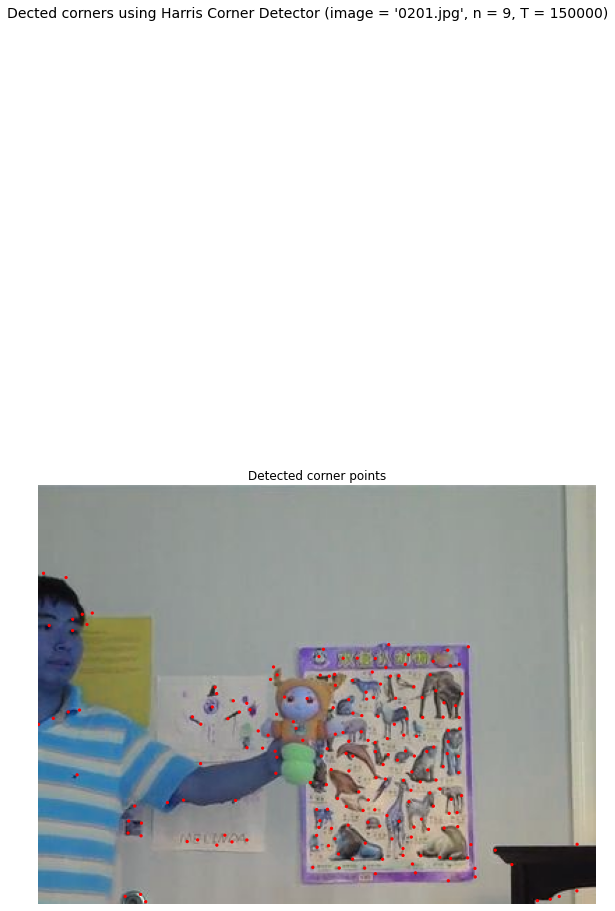

2  =  0201.jpg
174
4
170 : 179
[[  0.   0.   0.   0.  88.  87.  90.  95.  96.]
 [  0.   0.   0.   0.  85.  92.  98.  95.  81.]
 [  0.   0.   0.   0.  92.  85.  81.  81.  82.]
 [  0.   0.   0.   0.  90.  79.  76.  91. 114.]
 [  0.   0.   0.   0.  69.  82.  99. 114. 128.]
 [  0.   0.   0.   0.  70. 100. 128. 133. 127.]
 [  0.   0.   0.   0. 108. 122. 132. 133. 131.]
 [  0.   0.   0.   0. 130. 131. 130. 128. 129.]
 [  0.   0.   0.   0. 131. 132. 134. 133. 127.]]
x =  0.03785033841860921 , y =  170.82602661748155
vx =  0.0012882978534461062 , vy =  0.07944905047851158
x_new =  0.05073331695307027 , y_new =  171.62051712226665


66
7
62 : 71
[[  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 105. 139. 150. 125. 107. 121. 141. 146.]
 [  0.  47.  69.  7

vx =  0.20195922065224936 , vy =  0.18870510014182157
x_new =  203.7507978242587 , y_new =  241.913908014268


121
208
117 : 126
[[157. 153. 155. 162. 162. 158. 161. 170. 161.]
 [169. 165. 165. 167. 164. 159. 161. 168. 163.]
 [162. 165. 165. 163. 164. 168. 168. 164. 166.]
 [136. 130. 131. 141. 148. 144. 139. 138. 141.]
 [ 56.  43.  56.  95. 116. 111. 116. 133. 123.]
 [125. 120. 124. 134. 134. 122. 118. 124. 135.]
 [133. 154. 158. 139. 131. 139. 138. 125. 131.]
 [ 93. 141. 155. 101. 144. 148. 140. 136. 126.]
 [108. 131. 148. 136. 124. 108. 164. 131. 128.]]
x =  204.21244631005987 , y =  117.03795702795239
vx =  0.19690672890388836 , vy =  0.09902606795268157
x_new =  206.18151359909876 , y_new =  118.0282177074792


197
206
193 : 202
[[105. 105.  96.  85. 105. 105. 137. 165. 159.]
 [123.  70.  89.  79.  91.  87. 105. 148. 156.]
 [129.  71.  62.  73.  99.  99. 102. 154. 179.]
 [144.  84.  57.  67.  94.  76. 124. 159. 156.]
 [143.  77.  58.  61.  79.  87. 125. 172. 117.]
 [137.  77.  70. 

 [ 97. 113. 130. 110.  97. 124. 150. 168. 171.]]
x =  212.7789912443556 , y =  142.8518751022908
vx =  0.05106472839959906 , vy =  -0.15856120683771757
x_new =  213.2896385283516 , y_new =  141.26626303391362


277
219
273 : 282
[[149. 151. 159. 165. 164. 156. 165. 170. 171.]
 [167. 166. 165. 166. 171. 183. 179. 172. 166.]
 [159. 171. 177. 171. 172. 175. 168. 167. 171.]
 [172. 177. 169. 173. 185. 167. 179. 149. 127.]
 [173. 164. 142. 134. 140. 156. 169. 153. 141.]
 [178. 156. 126. 110. 110. 168. 178. 173. 164.]
 [172. 165. 152. 148. 151. 165. 168. 168. 158.]
 [176. 180. 180. 180. 181. 182. 181. 184. 178.]
 [160. 161. 159. 152. 144. 156. 153. 156. 157.]]
x =  215.5539973849962 , y =  273.86529902297804
vx =  0.19737816980198447 , vy =  0.12173916699328813
x_new =  217.52777908301604 , y_new =  275.08269069291094


127
222
123 : 132
[[130. 127. 125. 119. 119. 125. 124. 117. 116.]
 [118. 129. 121. 119. 127. 121. 143. 111. 123.]
 [100. 143. 159. 163. 136. 126. 147. 130. 157.]
 [ 90. 150. 1

x_new =  260.5803571582307 , y_new =  137.99858474492416


244
262
240 : 249
[[127. 151. 153. 113. 124. 130. 133. 134. 171.]
 [126. 151. 151. 114. 117.  99. 114. 115. 146.]
 [143. 144. 140. 136. 119.  89. 116. 104. 148.]
 [166. 144. 108. 123.  82.  63. 120. 104. 153.]
 [109. 135. 112.  64.  46.  52.  83. 101. 150.]
 [ 79. 128. 140.  83.  50.  78. 103. 131. 163.]
 [ 98. 141. 146.  70.  46. 131. 143. 138. 155.]
 [111. 124. 115.  59.  67. 163. 163. 126. 146.]
 [100.  92.  89.  79.  95. 140. 147. 124. 160.]]
x =  258.46394393594727 , y =  240.3663941374587
vx =  0.19492196225593633 , vy =  0.10397075861227009
x_new =  260.41316355850665 , y_new =  241.4061017235814


263
265
259 : 268
[[150. 120. 135. 166. 128. 164. 149.  79. 121.]
 [176. 107. 105. 175. 129. 157. 159. 127. 139.]
 [173. 118.  80. 160. 152. 161. 150. 146. 153.]
 [167. 148.  72. 136. 154. 162. 156. 157. 160.]
 [163. 169.  98. 141. 148. 167. 164. 157. 159.]
 [166. 167. 139. 167. 146. 174. 158. 157. 161.]
 [169. 167. 169. 165. 

x =  269.4167001700008 , y =  193.55734231915207
vx =  0.15898159442699383 , vy =  0.11657902371791154
x_new =  271.00651611427077 , y_new =  194.7231325563312


248
273
244 : 253
[[133. 114. 119. 153. 185. 184. 168. 176. 173.]
 [146. 105. 112. 144. 185. 156. 179. 169. 166.]
 [158. 103. 103. 117. 202. 173. 174. 170. 168.]
 [152. 107. 119.  91. 168. 194. 169. 168. 163.]
 [147. 105. 140. 103.  98. 169. 176. 173. 170.]
 [163. 106. 128. 146. 109. 156. 171. 169. 180.]
 [173. 135. 131. 172. 164. 170. 163. 159. 175.]
 [162. 175. 172. 170. 173. 170. 172. 177. 181.]
 [176. 169. 162. 178. 183. 166. 172. 166. 181.]]
x =  269.11786125172773 , y =  244.48832482473364
vx =  0.17075150231514324 , vy =  0.08619523086415218
x_new =  270.82537627487915 , y_new =  245.35027713337516


274
272
270 : 279
[[161. 165. 168. 169. 168. 169. 174. 178. 197.]
 [166. 167. 168. 167. 167. 167. 169. 170. 161.]
 [164. 162. 161. 163. 165. 168. 168. 168. 168.]
 [161. 160. 160. 162. 165. 170. 173. 175. 160.]
 [160. 162. 1

[[134. 145. 138. 141. 118. 116. 120. 112. 110.]
 [130. 140. 138. 144. 116. 109. 112. 111. 109.]
 [131. 146. 145. 145. 111. 105. 114. 109. 108.]
 [134. 151. 153. 154. 117. 108. 115. 107. 107.]
 [132. 145. 154. 162. 126. 109. 109. 106. 106.]
 [134. 115. 114. 135. 127. 107. 111. 105. 104.]
 [ 90.  69.  60.  81. 102. 112. 124. 110. 106.]
 [104. 108. 106. 114. 127. 127. 118. 114. 105.]
 [163. 166. 161. 156. 162. 161. 148. 131. 113.]]
x =  301.56719144550385 , y =  127.7852914248067
vx =  0.171682447061341 , vy =  0.1397577194385513
x_new =  303.28401591611726 , y_new =  129.18286861919222


170
305
166 : 175
[[134. 165.  64.  73. 160. 159. 151. 157. 156.]
 [131. 153.  56.  59. 143. 165. 157. 156. 156.]
 [131. 148.  76.  73. 136. 179. 157. 157. 155.]
 [134. 129.  71.  66. 115. 175. 157. 160. 153.]
 [123. 107.  63.  66. 111. 164. 166. 165. 151.]
 [106. 142. 145. 164. 179. 170. 157. 169. 150.]
 [167. 173. 186. 182. 169. 163. 159. 164. 160.]
 [182. 187. 177. 170. 178. 179. 166. 166. 163.]
 [177

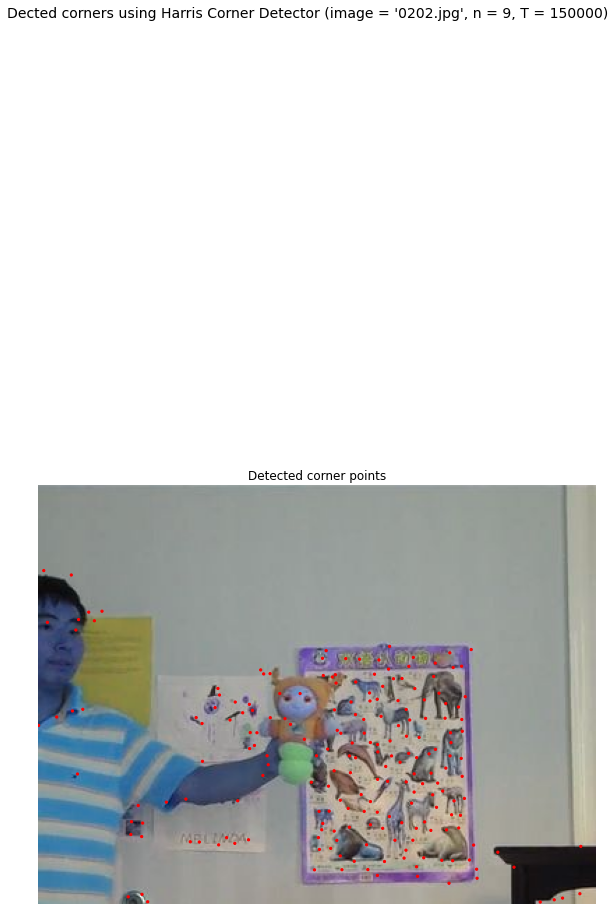

3  =  0202.jpg
175
4
171 : 180
[[  0.   0.   0.   0.  90.  92.  94.  93.  85.]
 [  0.   0.   0.   0.  87.  95.  89.  72.  71.]
 [  0.   0.   0.   0.  82.  74.  70.  84. 112.]
 [  0.   0.   0.   0.  69.  72.  88. 115. 134.]
 [  0.   0.   0.   0.  75.  95. 122. 137. 134.]
 [  0.   0.   0.   0. 106. 119. 130. 133. 132.]
 [  0.   0.   0.   0. 128. 133. 133. 127. 126.]
 [  0.   0.   0.   0. 134. 136. 137. 135. 129.]
 [  0.   0.   0.   0. 139. 130. 131. 145. 150.]]
x =  0.05073331695307027 , y =  171.62051712226665
vx =  0.0031233221197576426 , vy =  0.008260075259028558
x_new =  0.0819665381506467 , y_new =  171.70311787485693


64
7
60 : 69
[[  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 14

x_new =  211.14198988643375 , y_new =  260.0645526205277


208
215
204 : 213
[[174. 158. 162. 161. 168. 168. 162. 166. 165.]
 [166. 167. 170. 168. 165. 162. 165. 173. 170.]
 [166. 158. 161. 166. 163. 158. 166. 172. 167.]
 [172. 180. 162. 164. 161. 152. 159. 166. 171.]
 [163. 164. 111. 100.  96.  82.  83.  93. 112.]
 [143. 153.  79.  71.  78.  68.  67.  67.  84.]
 [130. 153.  72.  68.  80.  79.  89.  84.  92.]
 [129. 170.  78.  62.  63.  67.  95.  99. 107.]
 [155. 171.  84.  59.  63.  67.  82.  89. 106.]]
x =  211.87764420570622 , y =  204.17177474065647
vx =  0.10482105029103503 , vy =  0.18333326923677246
x_new =  212.92585470861655 , y_new =  206.0051074330242


251
215
247 : 256
[[175. 168. 173. 149. 151. 170. 168. 169. 173.]
 [164. 162. 167. 154. 160. 171. 164. 169. 176.]
 [149. 165. 153. 144. 161. 168. 162. 173. 176.]
 [165. 168. 131. 121. 155. 166. 164. 173. 161.]
 [167. 167. 111. 102. 151. 168. 166. 168. 140.]
 [173. 161. 148. 142. 148. 166. 181. 163. 126.]
 [164. 161. 138. 136.

vx =  0.1980328539291534 , vy =  0.07093257659752233
x_new =  253.9817678941811 , y_new =  183.46470452713746


240
255
236 : 245
[[190. 174. 195. 193. 158. 112. 100. 141. 162.]
 [185. 186. 191. 170. 131. 122. 123. 148. 144.]
 [165. 184. 181. 139. 106. 127. 141. 148. 130.]
 [157. 175. 173. 117. 110. 127. 147. 138. 137.]
 [175. 178. 167. 103. 132. 133. 150. 126. 146.]
 [184. 187. 154.  90. 143. 140. 148. 118. 143.]
 [176. 189. 138.  92. 142. 149. 142. 129. 147.]
 [178. 186. 132. 107. 143. 159. 140. 150. 164.]
 [175. 175. 148. 102. 106. 153. 144. 115. 126.]]
x =  251.54035390529984 , y =  236.9586684811233
vx =  0.17272257001563765 , vy =  0.13000368140797539
x_new =  253.2675796054562 , y_new =  238.25870529520307


118
255
114 : 123
[[159. 161. 160. 160. 159. 159. 159. 159. 159.]
 [159. 161. 160. 160. 159. 159. 159. 159. 159.]
 [162. 161. 165. 170. 158. 156. 172. 163. 157.]
 [148. 146. 148. 171. 174. 161. 158. 155. 163.]
 [130. 132. 100. 119. 148. 165. 169. 170. 173.]
 [129. 153.  91. 

x =  284.54386012925164 , y =  188.80798984286687
vx =  0.11005094616848862 , vy =  0.17609863685000324
x_new =  285.64436959093655 , y_new =  190.5689762113669


234
289
230 : 239
[[ 85.  98. 110. 164. 180. 176. 179. 174. 176.]
 [ 79.  81. 101. 164. 177. 174. 178. 176. 184.]
 [ 70.  46.  71. 158. 180. 177. 174. 176. 182.]
 [ 81.  35.  57. 157. 185. 183. 174. 179. 177.]
 [128.  88.  98. 174. 183. 182. 178. 183. 178.]
 [178. 159. 155. 195. 177. 177. 183. 181. 182.]
 [165. 180. 186. 183. 180. 184. 172. 181. 177.]
 [161. 180. 183. 180. 178. 188. 187. 184. 186.]
 [175. 179. 176. 180. 176. 177. 174. 179. 181.]]
x =  285.2884102981637 , y =  230.33210035071994
vx =  0.05904174614253181 , vy =  0.09972673123091783
x_new =  285.878827759589 , y_new =  231.32936766302913


152
291
148 : 157
[[ 92.  89. 102.  74.  67.  87. 110. 127. 120.]
 [ 61.  45.  91.  88.  78.  97. 104. 109. 104.]
 [ 70.  30.  80.  92.  89. 126. 115. 101.  95.]
 [123.  51.  65.  82. 101. 120. 103.  85.  80.]
 [161.  61.  45

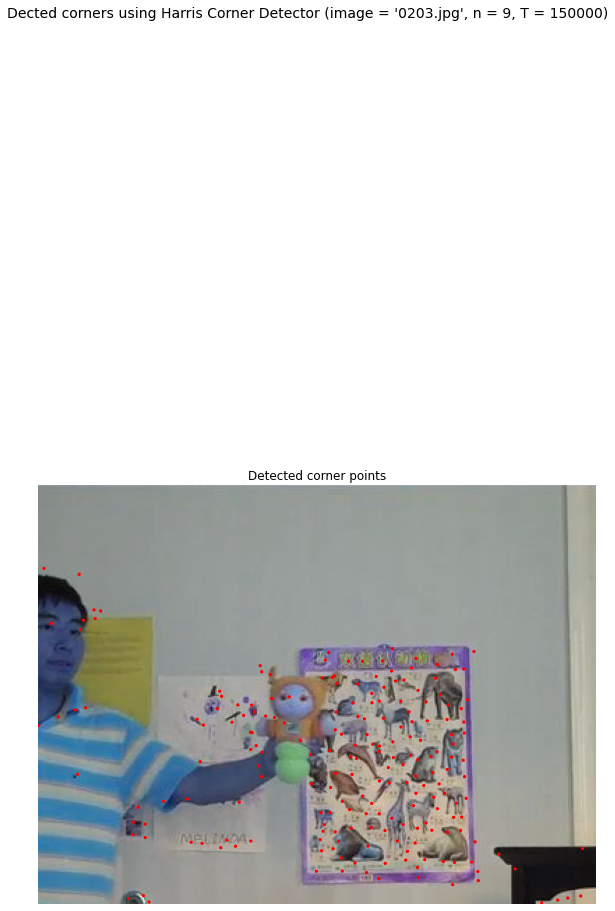

4  =  0203.jpg
175
4
171 : 180
[[  0.   0.   0.   0.  86.  90.  95.  96.  88.]
 [  0.   0.   0.   0.  89.  94.  89.  73.  70.]
 [  0.   0.   0.   0.  83.  73.  70.  85. 110.]
 [  0.   0.   0.   0.  70.  71.  88. 115. 133.]
 [  0.   0.   0.   0.  75.  95. 122. 137. 133.]
 [  0.   0.   0.   0. 105. 119. 131. 133. 133.]
 [  0.   0.   0.   0. 127. 133. 133. 126. 127.]
 [  0.   0.   0.   0. 132. 136. 138. 134. 131.]
 [  0.   0.   0.   0. 137. 130. 132. 144. 152.]]
x =  0.0819665381506467 , y =  171.70311787485693
vx =  -0.0006898476922582285 , vy =  0.05574187361669764
x_new =  0.0750680612280644 , y_new =  172.2605366110239


63
7
59 : 68
[[  0. 141. 141. 141. 141. 141. 141. 141. 141.]
 [  0. 139. 140. 140. 140. 140. 141. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 139. 140. 140. 140. 140. 140.]
 [  0. 139. 139. 139. 139. 140. 140. 140. 140.]
 [  0. 138. 138. 139. 139. 139. 139. 140. 140.]
 [  0. 138. 138. 138. 139. 139. 139. 139. 139.]
 [  0. 138. 138. 138.

x =  211.14198988643375 , y =  260.0645526205277
vx =  -0.04507975561131183 , vy =  0.12447028442404545
x_new =  210.69119233032063 , y_new =  261.30925546476817


210
216
206 : 215
[[163. 164. 168. 166. 161. 167. 173. 171. 165.]
 [175. 160. 167. 169. 161. 165. 170. 173. 184.]
 [179. 130. 124. 123. 110. 110. 116. 132. 160.]
 [159.  86.  77.  80.  68.  68.  68.  83.  96.]
 [159.  79.  71.  77.  73.  84.  78.  84.  89.]
 [173.  85.  69.  65.  67.  95.  95.  97. 102.]
 [181.  93.  61.  70.  54.  84.  89. 101. 110.]
 [188. 125.  53.  52.  59.  79.  84.  92. 105.]
 [177. 164.  80.  56.  63.  62.  73.  91. 102.]]
x =  212.92585470861655 , y =  206.0051074330242
vx =  -0.0017272547714341354 , vy =  0.022271685493441315
x_new =  212.90858216090223 , y_new =  206.2278242879586


251
216
247 : 256
[[168. 167. 151. 154. 163. 167. 174. 167. 184.]
 [159. 162. 158. 166. 166. 163. 174. 170. 179.]
 [163. 154. 150. 165. 165. 161. 175. 173. 165.]
 [167. 137. 126. 154. 166. 164. 174. 166. 144.]
 [163. 11

 [111. 111. 114. 115. 114. 115. 118. 124. 131.]]
x =  272.4508028858693 , y =  280.70401347359325
vx =  -0.009472433611286829 , vy =  0.059400667402751045
x_new =  272.35607854975643 , y_new =  281.2980201476208


218
280
214 : 223
[[ 59.  89.  87.  64.  64.  74.  86. 102. 156.]
 [ 49.  44.  34.  37.  48.  50.  63.  90.  82.]
 [ 36.  38.  69. 127. 157. 126.  75.  51.  72.]
 [134. 139. 155. 175. 184. 173. 152. 135. 137.]
 [175. 188. 195. 183. 168. 172. 181. 179. 173.]
 [169. 169. 175. 175. 172. 179. 181. 172. 178.]
 [163. 169. 177. 172. 162. 167. 175. 172. 173.]
 [150. 153. 164. 168. 159. 159. 170. 176. 176.]
 [161. 160. 173. 182. 172. 167. 178. 188. 179.]]
x =  276.20706073518426 , y =  214.7182494241942
vx =  -0.007118118333975833 , vy =  0.13571079390112578
x_new =  276.1358795518445 , y_new =  216.07535736320546


158
281
154 : 163
[[167. 155.  93.  50.  84. 110. 144. 132. 122.]
 [135. 120.  64.  48.  78.  90. 116. 140. 160.]
 [108. 129.  80.  59.  79. 121. 158. 162. 168.]
 [138. 14

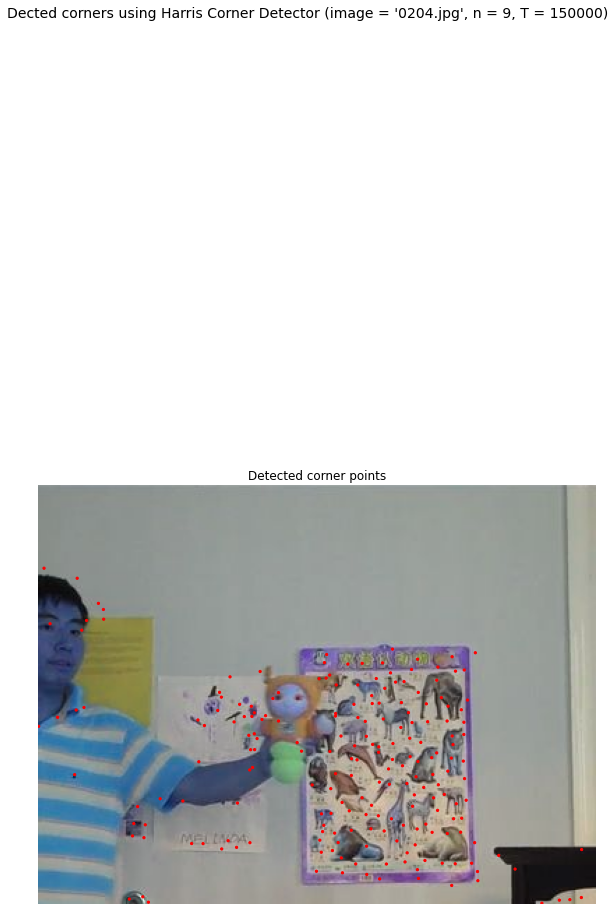

5  =  0204.jpg
176
4
172 : 181
[[  0.   0.   0.   0.  87.  95.  93.  79.  75.]
 [  0.   0.   0.   0.  87.  75.  70.  83. 108.]
 [  0.   0.   0.   0.  73.  72.  85. 110. 128.]
 [  0.   0.   0.   0.  72.  93. 121. 138. 134.]
 [  0.   0.   0.   0. 101. 117. 132. 137. 137.]
 [  0.   0.   0.   0. 127. 134. 133. 126. 127.]
 [  0.   0.   0.   0. 134. 137. 137. 132. 128.]
 [  0.   0.   0.   0. 136. 129. 131. 143. 151.]
 [  0.   0.   0.   0. 129. 124. 126. 136. 142.]]
x =  0.0750680612280644 , y =  172.2605366110239
vx =  0.008962192605504604 , vy =  -0.1610170519223005
x_new =  0.16468998728311046 , y_new =  170.6503660918009


62
7
58 : 67
[[  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 139. 139. 140. 141. 141. 141. 140. 140.]
 [  0. 139. 139. 140. 140. 140. 140. 141. 141.]
 [  0. 140. 139. 139. 139. 139. 140. 141. 141.]
 [  0. 140. 139. 139. 138. 139. 139. 140. 141.]
 [  0. 139. 139. 139. 139. 139. 139. 140. 140.]
 [  0. 137. 138. 139. 1

x =  147.5371795090602 , y =  165.31456706900104
vx =  -0.07246025919680887 , vy =  -0.031662140145357856
x_new =  146.81257691709212 , y_new =  164.99794566754747


161
156
157 : 166
[[ 94.  99.  95. 160. 173. 160. 171. 175. 172.]
 [ 97. 104.  97. 161. 178. 167. 168. 160. 157.]
 [ 98.  96. 118. 164. 168. 172. 166. 141. 147.]
 [132. 129. 158. 177. 161. 165. 158. 138. 156.]
 [173. 177. 179. 178. 174. 155. 132. 121. 146.]
 [173. 178. 167. 153. 157. 133. 104.  95. 125.]
 [169. 167. 165. 145. 105. 105.  92.  87. 126.]
 [160. 178. 166. 107.  70.  69.  78.  87. 106.]
 [159. 171. 148.  90.  76.  61.  64.  62.  84.]]
x =  152.55121790093773 , y =  157.88660635781991
vx =  -0.031253383762213045 , vy =  -0.040420602481934714
x_new =  152.2386840633156 , y_new =  157.48240033300056


193
156
189 : 198
[[ 83.  97. 115. 117. 138. 148. 156. 158. 163.]
 [ 92.  76.  96. 125. 142. 141. 152. 160. 157.]
 [ 84.  58.  85. 135. 153. 151. 164. 165. 153.]
 [ 84.  76. 104. 150. 150. 146. 153. 151. 146.]
 [131.

vx =  0.04051289341926523 , vy =  -0.004633974234355333
x_new =  222.18024543111807 , y_new =  127.60360282089336


199
228
195 : 204
[[ 66.  42.  32.  55.  72. 100. 113. 108. 109.]
 [110.  47.  24.  39.  41.  41.  78.  93. 100.]
 [169. 109.  41.  93.  71.  66.  41.  39.  61.]
 [179. 151.  62.  69.  91. 168. 139.  72.  40.]
 [175. 168. 119.  52.  84. 150. 180. 176. 138.]
 [183. 171. 168. 113.  61. 108. 171. 174. 163.]
 [172. 173. 174. 164. 139. 113. 160. 180. 160.]
 [170. 180. 174. 178. 174. 165. 174. 173. 165.]
 [179. 173. 175. 180. 178. 181. 164. 174. 174.]]
x =  224.37714014444884 , y =  195.50329394155497
vx =  -0.1073678320311004 , vy =  -0.051062127445329515
x_new =  223.30346182413783 , y_new =  194.9926726671017


236
226
232 : 241
[[182. 147.  99.  99. 105. 117. 144. 153. 160.]
 [184. 185. 121.  79. 106. 102. 114. 133. 151.]
 [174. 181. 135.  84.  95.  98. 101. 120. 145.]
 [173. 174. 172. 139.  85.  89. 101.  93. 130.]
 [180. 177. 177. 180. 153. 126.  86.  85.  82.]
 [179. 176

x_new =  267.131467202326 , y_new =  169.18586031391993


198
270
194 : 203
[[166. 151. 118. 111. 140. 162. 175. 185. 175.]
 [148. 153. 118.  91. 108. 135. 165. 186. 177.]
 [ 81.  91.  75.  94. 124. 111. 119. 169. 182.]
 [105. 109. 104.  94. 100.  95. 100. 141. 172.]
 [127.  86.  96.  89. 102. 124. 123. 142. 180.]
 [114.  88.  79. 105. 139. 172. 164. 167. 194.]
 [ 95. 109. 108. 147. 171. 184. 176. 181. 183.]
 [ 98. 122. 149. 178. 184. 177. 183. 189. 152.]
 [106. 139. 164. 181. 186. 179. 193. 185. 119.]]
x =  266.3865968749559 , y =  194.0511772544804
vx =  0.001227061255700327 , vy =  -0.025069210825603115
x_new =  266.3988674875129 , y_new =  193.80048514622436


128
275
124 : 133
[[112.  89. 124. 115. 116. 125. 136. 130.  98.]
 [119. 107. 136. 122. 120. 115. 139. 121. 121.]
 [141. 110. 124. 125. 140. 124. 142. 131. 119.]
 [152. 114. 126. 138. 156. 121. 131. 152. 102.]
 [150. 121. 134. 128. 119.  95. 124. 150. 102.]
 [152. 112. 122. 117. 112.  95. 143. 122. 114.]
 [159. 109. 114. 123.

x_new =  303.84932264451686 , y_new =  198.0585832178227


252
306
248 : 257
[[154. 166. 175. 187. 186. 171. 176. 173. 178.]
 [ 99. 116. 143. 176. 183. 164. 177. 172. 177.]
 [ 94.  85.  96. 138. 178. 190. 173. 170. 177.]
 [128. 110.  93. 110. 150. 178. 180. 177. 182.]
 [137. 128. 123. 100. 109. 163. 180. 175. 178.]
 [126. 129. 128. 107. 102. 128. 168. 182. 175.]
 [121. 135. 137. 124. 109. 104. 146. 183. 174.]
 [123. 139. 138. 136. 125. 104. 119. 165. 179.]
 [122. 136. 132. 135. 131. 108. 100. 135. 177.]]
x =  302.5991350378991 , y =  248.15060289574228
vx =  -0.056385783898048505 , vy =  -0.07624004257271678
x_new =  302.0352771989186 , y_new =  247.3882024700151


135
309
131 : 140
[[150. 113. 115. 105. 108. 108. 106.  91. 138.]
 [164. 130. 104. 107. 101. 104. 112.  91. 129.]
 [102. 110. 122. 112. 107. 105. 113.  94. 129.]
 [ 87. 105. 118. 106. 103.  95. 105.  94. 131.]
 [141. 139. 127. 114. 112.  91.  99.  93. 131.]
 [169. 169. 164. 149. 146. 105. 103.  96. 129.]
 [171. 172. 174. 169

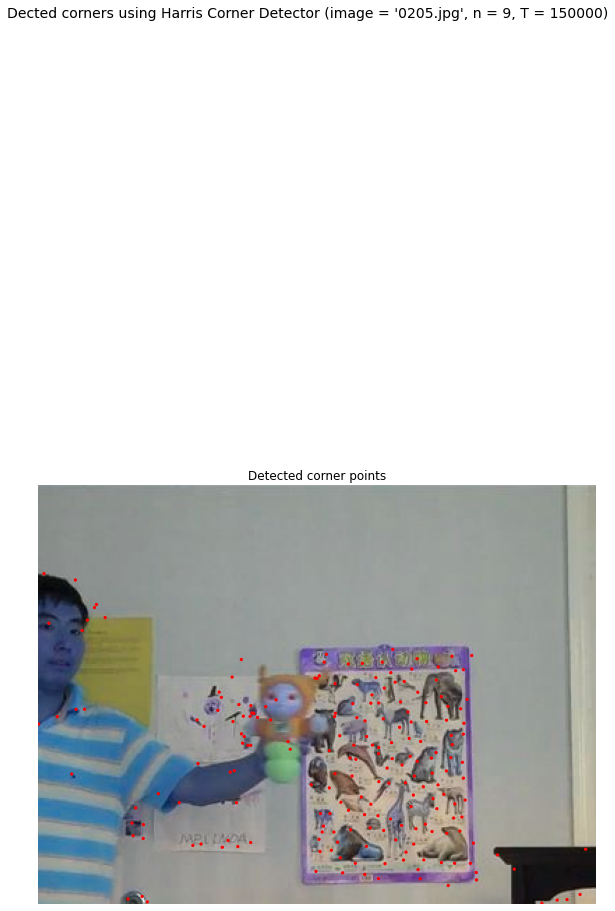

6  =  0205.jpg
174
4
170 : 179
[[  0.   0.   0.   0.  89.  89.  91.  92.  88.]
 [  0.   0.   0.   0.  87.  90.  95.  94.  86.]
 [  0.   0.   0.   0.  86.  92.  89.  78.  80.]
 [  0.   0.   0.   0.  96.  77.  73.  96. 118.]
 [  0.   0.   0.   0.  78.  77.  94. 121. 131.]
 [  0.   0.   0.   0.  70. 104. 131. 131. 122.]
 [  0.   0.   0.   0. 103. 128. 138. 126. 122.]
 [  0.   0.   0.   0. 130. 131. 129. 127. 128.]
 [  0.   0.   0.   0. 131. 126. 128. 137. 136.]]
x =  0.16468998728311046 , y =  170.6503660918009
vx =  -0.00018168143217105626 , vy =  -0.25122793681652694
x_new =  0.1628731729613999 , y_new =  168.1380867236356


66
7
62 : 71
[[  0. 144. 142. 140. 139. 140. 141. 141. 140.]
 [  0. 140. 140. 142. 143. 144. 143. 139. 136.]
 [  0. 134. 134. 135. 138. 140. 142. 141. 140.]
 [  0. 144. 141. 137. 135. 136. 139. 141. 142.]
 [  0. 140. 139. 137. 137. 138. 139. 139. 138.]
 [  0. 113. 118. 127. 136. 142. 142. 138. 134.]
 [  0.  40.  37.  61. 100. 104.  74.  58.  68.]
 [  0.  16.  13.  2

x =  199.68270757296423 , y =  137.96150411001798
vx =  -0.5275273042117259 , vy =  -0.22680276851212744
x_new =  194.40743453084698 , y_new =  135.69347642489672


193
212
189 : 198
[[ 73. 134. 179.  91.  22.  61.  64. 137. 188.]
 [ 54.  96. 171.  97.  30.  72.  63. 162. 188.]
 [ 54.  87. 176. 132.  32.  81.  77. 168. 185.]
 [159. 150. 175. 124.  42.  83.  89. 143. 176.]
 [181. 170. 170. 134.  50.  72.  89. 115. 178.]
 [159. 162. 160. 130.  32.  38.  59.  71. 145.]
 [141. 158. 173. 149. 125. 116. 126. 114. 161.]
 [159. 172. 168. 170. 180. 170. 176. 173. 165.]
 [166. 177. 154. 142. 160. 157. 159. 152. 151.]]
x =  208.41067306935773 , y =  189.79028363702557
vx =  -0.011916444690844439 , vy =  -0.08875331654772908
x_new =  208.29150862244927 , y_new =  188.90275047154827


265
213
261 : 270
[[161. 169. 158. 160. 170. 164. 158. 168. 143.]
 [162. 160. 134. 137. 163. 151. 138. 167. 166.]
 [168. 154. 127. 134. 163. 146. 130. 164. 170.]
 [170. 165. 149. 153. 172. 156. 146. 171. 173.]
 [167. 

 [ 60.  62. 134. 176. 166. 161. 170. 173. 171.]]
x =  251.15790123676868 , y =  213.01250979028399
vx =  0.014243272104804625 , vy =  -0.1083951843231933
x_new =  251.30033395781672 , y_new =  211.92855794705204


137
256
133 : 142
[[143.  83.  92. 117. 149. 159. 113. 108.  97.]
 [114.  88.  85.  98. 121. 126. 112. 122. 104.]
 [ 92. 112.  98.  79.  80.  87. 100. 113. 109.]
 [122. 147. 132. 122. 128. 130. 134. 128. 131.]
 [169. 172. 166. 173. 179. 170. 168. 167. 166.]
 [174. 165. 171. 173. 165. 161. 164. 171. 167.]
 [170. 162. 175. 168. 159. 173. 168. 156. 168.]
 [162. 168. 177. 179. 171. 174. 171. 159. 160.]
 [168. 145. 137. 109. 113. 136. 178. 174. 152.]]
x =  252.5614109104072 , y =  133.8325744021977
vx =  -0.004072007907102375 , vy =  -0.14781964564063982
x_new =  252.52069083133617 , y_new =  132.3543779457913


187
257
183 : 192
[[118. 158. 165. 123. 144. 172. 170. 167. 165.]
 [105. 166. 166. 133. 153. 177. 171. 175. 162.]
 [123. 169. 140. 109. 153. 181. 168. 170. 165.]
 [173. 17

vx =  0.08357749768124306 , vy =  -0.18532631079411788
x_new =  304.6850976213293 , y_new =  196.2053201098815


251
306
247 : 256
[[184. 186. 177. 171. 169. 163. 163. 164. 168.]
 [149. 169. 178. 186. 186. 176. 172. 166. 165.]
 [ 86. 108. 135. 166. 180. 173. 174. 166. 164.]
 [ 92.  90. 102. 137. 170. 178. 174. 168. 169.]
 [133. 108.  92. 113. 152. 171. 175. 173. 175.]
 [126. 125. 126. 101. 110. 167. 181. 167. 178.]
 [129. 130. 129. 111. 107. 133. 168. 179. 171.]
 [130. 133. 130. 123. 110. 101. 145. 183. 169.]
 [126. 134. 129. 128. 119.  95. 121. 165. 176.]]
x =  302.0352771989186 , y =  247.3882024700151
vx =  0.051214497740959354 , vy =  -0.07482138024784393
x_new =  302.5474221763282 , y_new =  246.63998866753667


135
308
131 : 140
[[137. 150. 106. 115. 114. 101. 106. 107.  98.]
 [144. 155. 131. 110. 113. 107. 113. 110.  90.]
 [101. 119. 116. 109. 106. 102. 109. 111.  93.]
 [ 71.  96. 114. 118. 105. 101. 102. 108.  94.]
 [128. 138. 147. 143. 123. 113.  96. 101.  92.]
 [179. 176. 171

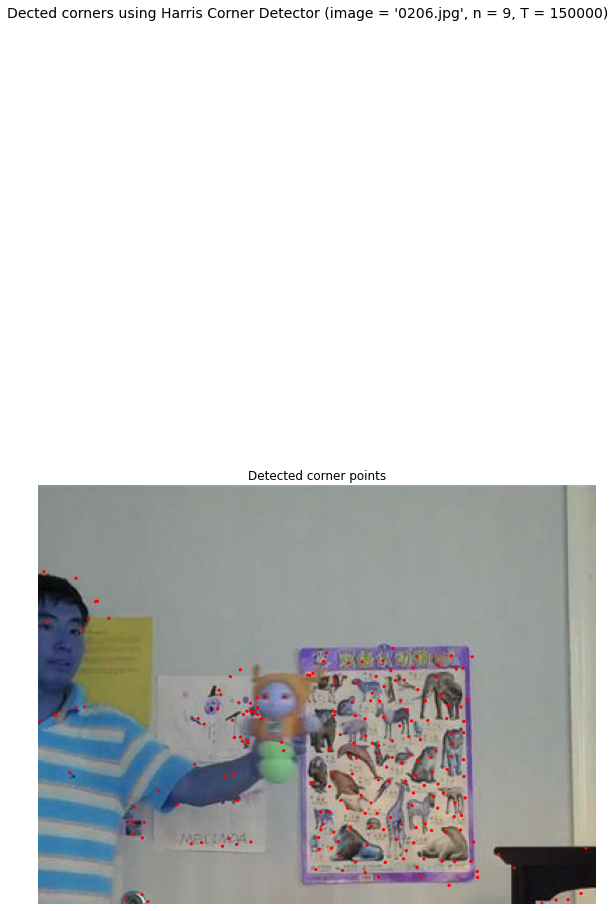

7  =  0206.jpg
172
4
168 : 177
[[  0.   0.   0.   0.  87.  84.  84.  87.  91.]
 [  0.   0.   0.   0.  87.  86.  88.  92.  93.]
 [  0.   0.   0.   0.  90.  91.  94.  95.  90.]
 [  0.   0.   0.   0.  87.  89.  92.  91.  85.]
 [  0.   0.   0.   0.  92.  88.  79.  75.  88.]
 [  0.   0.   0.   0.  84.  76.  79. 101. 121.]
 [  0.   0.   0.   0.  71.  87. 111. 129. 132.]
 [  0.   0.   0.   0.  86. 118. 139. 131. 121.]
 [  0.   0.   0.   0. 122. 133. 132. 121. 121.]]
x =  0.1628731729613999 , y =  168.1380867236356
vx =  0.0013593733123001724 , vy =  -0.14043228061571664
x_new =  0.1764669060844016 , y_new =  166.73376391747846


65
7
61 : 70
[[  0. 145. 143. 140. 139. 139. 140. 142. 143.]
 [  0. 141. 140. 138. 136. 135. 135. 137. 140.]
 [  0. 138. 140. 143. 144. 142. 142. 142. 144.]
 [  0. 136. 137. 139. 139. 139. 139. 141. 142.]
 [  0. 144. 141. 137. 136. 137. 140. 141. 142.]
 [  0. 143. 140. 139. 141. 146. 147. 144. 140.]
 [  0. 109. 110. 116. 126. 134. 132. 121. 111.]
 [  0.  35.  19.  33.

x =  159.94972721732748 , y =  166.98001709070715
vx =  -0.30881600653240426 , vy =  0.07581857264907903
x_new =  156.86156715200343 , y_new =  167.73820281719793


187
178
183 : 192
[[107. 112. 114. 112. 112. 114. 113. 114. 116.]
 [ 98.  98.  97.  99. 109. 121. 132. 134. 135.]
 [103. 104. 101. 100. 109. 122. 144. 148. 151.]
 [ 99. 107. 107. 105. 113. 126. 135. 141. 147.]
 [112. 110. 101.  96. 105. 121. 145. 152. 157.]
 [154. 153. 147. 139. 130. 124. 119. 118. 128.]
 [154. 156. 157. 156. 154. 153. 139. 130. 126.]
 [153. 154. 155. 158. 161. 162. 158. 150. 145.]
 [151. 150. 150. 153. 155. 157. 163. 159. 159.]]
x =  174.2766699348837 , y =  183.67523474077257
vx =  -0.1668869493460734 , vy =  0.13604036203649905
x_new =  172.60780044142297 , y_new =  185.03563836113756


217
199
213 : 222
[[121. 161. 181. 161. 148. 138.  60.   6.  43.]
 [124. 168. 178. 172. 177. 176. 113.  39.  22.]
 [128. 166. 175. 182. 175. 164. 143.  80.   5.]
 [133. 170. 175. 143.  90.  64.  60.  64.  75.]
 [135. 156.


257
260
253 : 262
[[107. 117. 136. 114. 112. 160. 121. 140. 167.]
 [117. 131. 147. 134. 125. 150. 121. 151. 154.]
 [131. 139. 158. 131. 136. 137. 101. 142. 158.]
 [116. 117. 159. 126. 134. 138. 105. 138. 160.]
 [102. 105. 157. 130. 135. 139. 113. 132. 165.]
 [106. 129. 160. 141. 141. 132. 120. 134. 182.]
 [108. 157. 165. 151. 153. 137. 139. 137. 174.]
 [122. 155. 169. 144. 144. 154. 148.  96. 179.]
 [124. 157. 169. 146. 144. 150. 155.  83. 145.]]
x =  256.3692563788221 , y =  253.18264316614352
vx =  0.003394888498836411 , vy =  -0.07802238071226258
x_new =  256.4032052638105 , y_new =  252.40241935902088


175
262
171 : 180
[[106.  71.  81.  85.  75.  60.  68.  90.  93.]
 [ 88.  77.  78.  67.  55.  76.  72.  80. 153.]
 [ 87.  80.  74.  79.  99. 131. 107.  69. 137.]
 [127. 128. 139. 138. 154. 172. 147.  72.  98.]
 [172. 170. 170. 170. 171. 167. 170. 109. 103.]
 [175. 164. 159. 170. 172. 159. 173. 124. 116.]
 [169. 162. 169. 169. 168. 165. 175. 115. 107.]
 [175. 173. 168. 162. 159. 167

 [176. 173. 172. 176. 172. 174. 170. 160. 160.]]
x =  297.9937570379261 , y =  236.98271278497435
vx =  -0.07485827524002653 , vy =  -0.04279337065317213
x_new =  297.2451742855259 , y_new =  236.55477907844264


290
298
286 : 295
[[154. 159. 155. 146. 136. 129. 131. 132. 125.]
 [149. 149. 143. 132. 121. 115. 102. 104. 100.]
 [123. 115. 109. 107. 110. 112. 111. 116. 114.]
 [158. 154. 151. 151. 152. 154. 154. 160. 158.]
 [165. 167. 166. 163. 160. 158. 156. 163. 160.]
 [160. 158. 157. 158. 162. 165. 157. 163. 162.]
 [162. 162. 162. 161. 161. 161. 161. 161. 161.]
 [162. 162. 162. 161. 161. 161. 161. 161. 161.]
 [162. 162. 161. 161. 161. 161. 161. 161. 161.]]
x =  294.36432539895657 , y =  286.31419795046344
vx =  0.09706522708009041 , vy =  -0.1573671821097566
x_new =  295.33497766975745 , y_new =  284.7405261293659


135
303
131 : 140
[[130. 123. 126. 140. 143. 141. 156. 110. 112.]
 [106. 117. 141. 135. 125. 146. 151. 125. 109.]
 [ 77.  95. 115. 108.  90.  95. 106. 111. 118.]
 [ 92.  72.

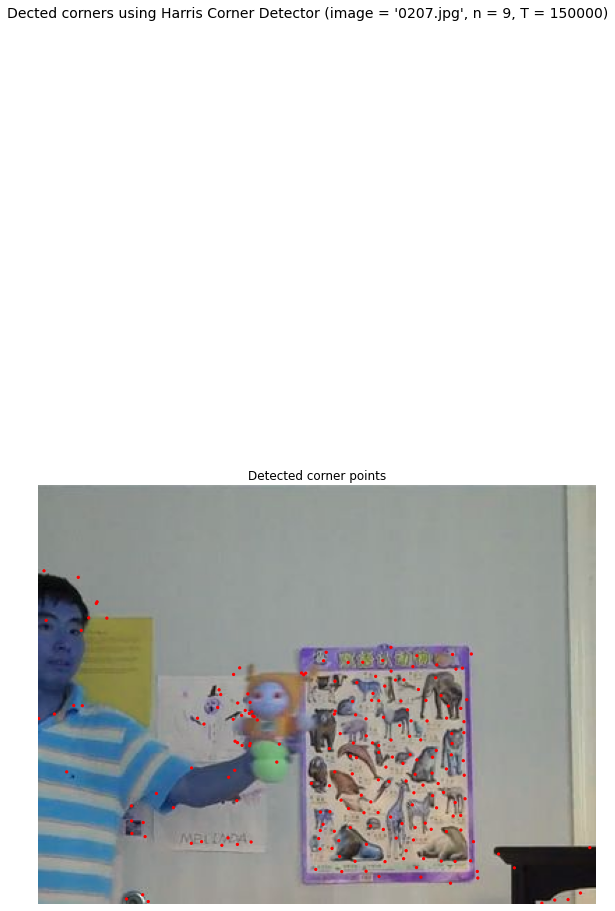

8  =  0207.jpg
170
4
166 : 175
[[  0.   0.   0.   0.  85.  88.  90.  89.  88.]
 [  0.   0.   0.   0.  88.  88.  88.  87.  88.]
 [  0.   0.   0.   0.  88.  86.  87.  89.  91.]
 [  0.   0.   0.   0.  85.  85.  89.  94.  93.]
 [  0.   0.   0.   0.  85.  87.  91.  92.  88.]
 [  0.   0.   0.   0.  90.  91.  91.  87.  81.]
 [  0.   0.   0.   0.  92.  85.  81.  85.  94.]
 [  0.   0.   0.   0.  77.  79.  87. 103. 120.]
 [  0.   0.   0.   0.  73.  98. 122. 131. 130.]]
x =  0.1764669060844016 , y =  166.73376391747846
vx =  0.005832728542206454 , vy =  -0.22649922360571856
x_new =  0.23479419150646613 , y_new =  164.46877168142126


64
7
60 : 69
[[  0. 141. 141. 140. 138. 137. 139. 143. 146.]
 [  0. 140. 140. 142. 143. 144. 142. 139. 136.]
 [  0. 144. 141. 137. 137. 138. 140. 140. 139.]
 [  0. 145. 144. 142. 140. 141. 143. 146. 148.]
 [  0. 133. 137. 141. 142. 139. 137. 136. 138.]
 [  0. 143. 143. 141. 138. 135. 136. 140. 143.]
 [  0. 144. 140. 136. 138. 142. 145. 145. 143.]
 [  0.  91.  95. 107

 [126. 148. 126. 113. 128. 158. 174. 172. 171.]]
x =  200.89441922987814 , y =  252.75995186841482
vx =  -0.07289933073651313 , vy =  -0.06328135116675845
x_new =  200.165425922513 , y_new =  252.12713835674722


264
205
260 : 269
[[148. 126. 113. 128. 158. 174. 172. 171. 168.]
 [130. 107. 109. 115. 160. 172. 145. 132. 147.]
 [ 99.  85.  90. 119. 164. 168. 134. 134. 162.]
 [128. 128. 101. 134. 173. 175. 149. 158. 181.]
 [175. 184. 133. 126. 169. 182. 159. 153. 165.]
 [136. 151. 125. 110. 147. 167. 158. 152. 156.]
 [112. 122. 124. 126. 145. 154. 155. 164. 169.]
 [174. 169. 166. 161. 168. 162. 156. 165. 172.]
 [174. 164. 149. 150. 160. 160. 157. 164. 168.]]
x =  201.77961785602378 , y =  260.2298314385266
vx =  -0.05868619729690084 , vy =  -0.0001277342411509074
x_new =  201.19275588305476 , y_new =  260.2285540961151


250
205
246 : 255
[[172. 170. 117.  86. 167. 141.  99. 134. 143.]
 [177. 173. 121. 113. 187. 131. 102. 158. 162.]
 [175. 159. 105. 114. 171. 103.  89. 167. 183.]
 [167. 1

 [173. 171. 168. 163. 160. 174. 174. 158. 160.]]
x =  252.73044873537737 , y =  132.6573638069364
vx =  -0.04898883049452846 , vy =  -0.08495407494758483
x_new =  252.24056043043208 , y_new =  131.80782305746055


186
256
182 : 191
[[175. 126. 153. 162. 110. 156. 180. 163. 168.]
 [147. 108. 158. 168. 123. 149. 179. 168. 171.]
 [ 98.  95. 164. 165. 128. 154. 181. 166. 162.]
 [130. 138. 172. 130.  96. 144. 177. 167. 164.]
 [182. 177. 175. 129. 104. 149. 166. 171. 170.]
 [171. 163. 173. 177. 170. 182. 158. 167. 162.]
 [177. 170. 158. 157. 166. 163. 156. 158. 167.]
 [123. 155. 173. 169. 165. 162. 161. 166. 157.]
 [139. 166. 170. 153. 152. 160. 154. 142. 163.]]
x =  252.69191653446384 , y =  182.13737066880535
vx =  0.02548773511542493 , vy =  0.06864719257341101
x_new =  252.9467938856181 , y_new =  182.82384259453946


241
256
237 : 246
[[184. 187. 177. 123. 116. 118. 144. 157. 140.]
 [171. 189. 160.  97. 133. 134. 140. 138. 149.]
 [160. 175. 139. 103. 144. 149. 138. 124. 138.]
 [169. 159

vx =  -0.082127488428183 , vy =  -0.005266930279895913
x_new =  285.6786753010655 , y_new =  213.24518994703186


272
292
268 : 277
[[ 84.  67.  62. 106. 166. 135. 111.  98.  77.]
 [ 51.  37.  53. 120. 160. 122.  87.  76.  64.]
 [ 55.  54.  68. 120. 134. 113.  85.  71.  58.]
 [151. 161. 144. 142. 109. 105.  79.  59.  48.]
 [177. 182. 149. 122.  89.  88.  65.  56.  72.]
 [170. 168. 152. 148. 137. 146. 140. 140. 158.]
 [165. 168. 165. 170. 158. 167. 173. 171. 165.]
 [151. 162. 152. 138. 153. 147. 154. 164. 162.]
 [150. 160. 158. 143. 144. 136. 151. 180. 175.]]
x =  288.6886269164402 , y =  268.8902633406297
vx =  0.009357809837233312 , vy =  0.004314713527537169
x_new =  288.7822050148126 , y_new =  268.9334104759051


223
294
219 : 228
[[187. 175. 182. 184. 170. 172. 178. 171. 171.]
 [181. 161. 168. 176. 151. 136. 155. 145. 169.]
 [146. 105.  84. 117. 109. 115. 147. 108.  83.]
 [160. 126. 106.  90.  88. 129. 138. 118. 110.]
 [182. 178. 190. 134.  89. 140. 137. 127. 138.]
 [179. 187. 187

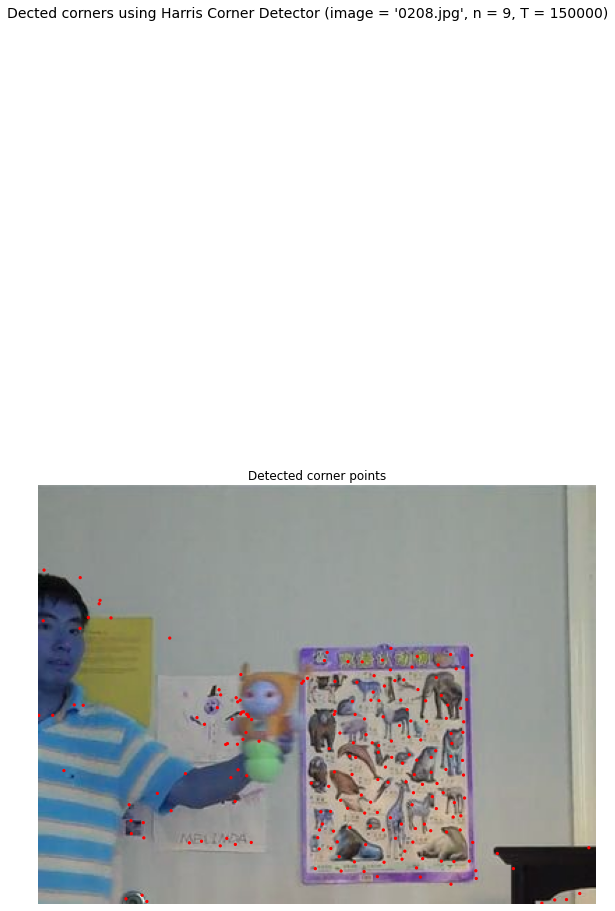

9  =  0208.jpg
168
4
164 : 173
[[  0.   0.   0.   0.  83.  81.  81.  85.  89.]
 [  0.   0.   0.   0.  87.  86.  86.  87.  89.]
 [  0.   0.   0.   0.  85.  85.  86.  86.  87.]
 [  0.   0.   0.   0.  84.  84.  85.  88.  89.]
 [  0.   0.   0.   0.  87.  87.  88.  91.  93.]
 [  0.   0.   0.   0.  87.  87.  88.  88.  88.]
 [  0.   0.   0.   0.  85.  87.  88.  85.  82.]
 [  0.   0.   0.   0.  85.  90.  92.  88.  84.]
 [  0.   0.   0.   0.  96.  79.  69.  81. 106.]]
x =  0.23479419150646613 , y =  164.46877168142126
vx =  0.001090444890913301 , vy =  0.07178445103414682
x_new =  0.24569864041559913 , y_new =  165.18661619176274


64
7
60 : 69
[[  0. 139. 139. 139. 138. 137. 139. 142. 145.]
 [  0. 139. 140. 142. 145. 145. 144. 140. 137.]
 [  0. 143. 141. 138. 138. 140. 142. 141. 140.]
 [  0. 144. 143. 142. 141. 142. 144. 146. 148.]
 [  0. 132. 137. 142. 143. 141. 138. 137. 138.]
 [  0. 143. 143. 142. 139. 137. 138. 141. 144.]
 [  0. 140. 137. 134. 136. 141. 144. 144. 142.]
 [  0.  84.  88. 100

x =  135.43248319578507 , y =  184.6495695154527
vx =  -0.09127108782889928 , vy =  -0.09646091700255283
x_new =  134.51977231749606 , y_new =  183.68496034542716


189
146
185 : 194
[[164. 163. 160. 157. 157. 157. 149. 138. 121.]
 [161. 160. 157. 152. 148. 146. 143. 134. 118.]
 [158. 161. 162. 160. 158. 157. 149. 138. 119.]
 [163. 164. 159. 161. 161. 151. 148. 131. 109.]
 [161. 162. 158. 160. 160. 150. 148. 132. 113.]
 [161. 162. 157. 159. 158. 148. 144. 130. 115.]
 [162. 162. 156. 157. 156. 146. 138. 126. 113.]
 [159. 159. 154. 157. 156. 146. 136. 124. 112.]
 [153. 155. 153. 157. 158. 149. 139. 127. 112.]]
x =  142.5807266888618 , y =  185.11568847419716
vx =  -0.7178932521908521 , vy =  -0.30895746509647826
x_new =  135.40179416695327 , y_new =  182.02611382323238


189
138
185 : 194
[[157. 157. 157. 158. 159. 161. 158. 161. 164.]
 [156. 157. 158. 159. 158. 158. 161. 161. 161.]
 [155. 157. 159. 159. 158. 156. 159. 158. 158.]
 [154. 155. 157. 158. 160. 161. 161. 160. 163.]
 [155. 155

x =  247.20026846863567 , y =  246.57986320393505
vx =  -0.13333724135884895 , vy =  0.1053974153957546
x_new =  245.8668960550472 , y_new =  247.6338373578926


205
252
201 : 210
[[ 66. 104. 105.  64.  85. 135. 192. 181. 165.]
 [ 72.  96.  80.  83. 165. 172. 175. 165. 171.]
 [ 95.  92.  63. 148. 178. 179. 176. 167. 174.]
 [107.  90.  71. 163. 183. 174. 170. 173. 172.]
 [156. 155. 153. 190. 186. 174. 167. 171. 176.]
 [174. 181. 190. 178. 174. 175. 176. 172. 158.]
 [174. 179. 186. 171. 169. 176. 181. 172. 150.]
 [173. 181. 179. 182. 181. 175. 172. 172. 168.]
 [172. 179. 174. 181. 180. 176. 175. 175. 169.]]
x =  248.69161877627803 , y =  201.48263641364557
vx =  -0.18111816238865291 , vy =  0.0674047468704355
x_new =  246.8804371523915 , y_new =  202.1566838823499


273
251
269 : 278
[[110.  89.  79.  70.  97. 180. 163. 123. 117.]
 [110.  96.  64.  49. 103. 179. 165. 130. 119.]
 [ 97.  79.  40.  46. 134. 174. 175. 164. 156.]
 [ 63.  44.  60. 114. 165. 172. 170. 170. 164.]
 [149. 151. 171

x_new =  300.50012930030437 , y_new =  247.25066359378155


133
308
129 : 138
[[146. 135. 101. 120. 113. 107. 106. 109.  98.]
 [147. 148. 107. 121. 112. 107. 105. 109.  97.]
 [150. 157. 108. 115. 111. 106. 105. 109.  97.]
 [150. 155. 126. 105. 109. 100. 111. 114.  95.]
 [ 85.  98. 111. 126. 113. 104. 109. 111.  94.]
 [ 79.  98. 116. 124. 112. 103.  97. 100.  90.]
 [156. 161. 151. 133. 128. 119.  96.  93.  87.]
 [178. 175. 171. 163. 162. 151. 110.  97.  89.]
 [161. 160. 164. 169. 172. 165. 112.  95.  89.]]
x =  304.3053274763856 , y =  129.98694679175216
vx =  -0.14002643104195128 , vy =  0.17685694560430293
x_new =  302.9050631659661 , y_new =  131.75551624779519


173
308
169 : 178
[[ 63.  87. 162. 161. 150. 160. 132.  81.  85.]
 [ 53.  64. 143. 169. 152. 163. 135.  83.  85.]
 [109. 114. 160. 169. 154. 165. 138.  84.  84.]
 [182. 176. 179. 164. 152. 169. 136.  77.  87.]
 [189. 171. 172. 163. 155. 169. 135.  80.  89.]
 [177. 175. 181. 175. 160. 170. 136.  85.  94.]
 [179. 181. 178. 168

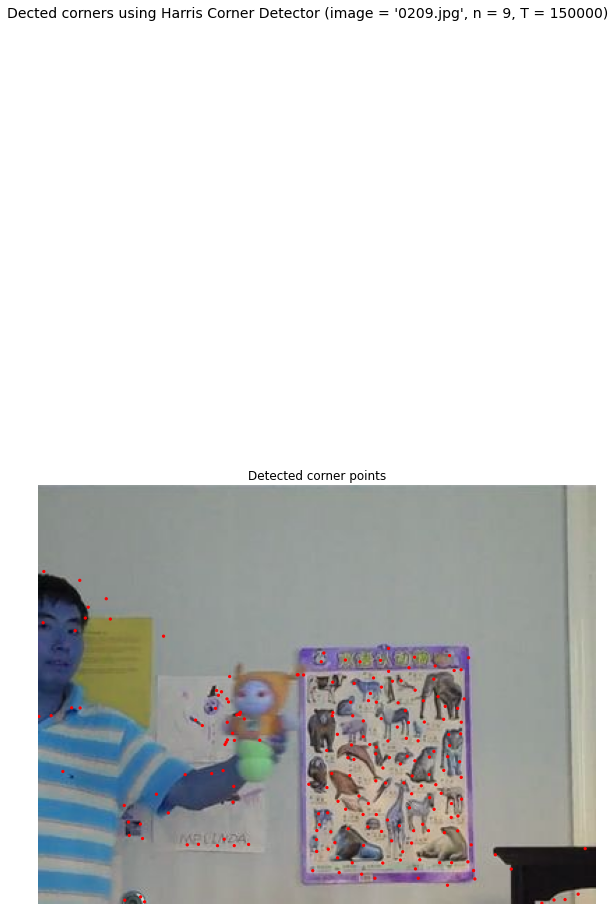

10  =  0209.jpg
169
4
165 : 174
[[  0.   0.   0.   0.  79.  83.  85.  83.  83.]
 [  0.   0.   0.   0.  81.  85.  87.  84.  81.]
 [  0.   0.   0.   0.  88.  88.  87.  84.  81.]
 [  0.   0.   0.   0.  86.  85.  86.  88.  89.]
 [  0.   0.   0.   0.  83.  83.  86.  89.  87.]
 [  0.   0.   0.   0.  86.  87.  88.  86.  79.]
 [  0.   0.   0.   0.  90.  90.  89.  83.  76.]
 [  0.   0.   0.   0.  96.  82.  73.  85. 107.]
 [  0.   0.   0.   0.  68.  82. 101. 116. 124.]]
x =  0.24569864041559913 , y =  165.18661619176274
vx =  0.016911858948040308 , vy =  -0.03664668818464349
x_new =  0.4148172298960022 , y_new =  164.8201493099163


65
7
61 : 70
[[  0. 146. 143. 141. 142. 141. 140. 142. 144.]
 [  0. 140. 141. 139. 137. 136. 139. 140. 140.]
 [  0. 138. 143. 145. 143. 144. 147. 146. 141.]
 [  0. 138. 140. 141. 139. 139. 141. 141. 138.]
 [  0. 145. 141. 138. 138. 137. 136. 137. 141.]
 [  0. 142. 136. 138. 146. 146. 138. 136. 143.]
 [  0. 106. 102. 113. 132. 135. 120. 112. 118.]
 [  0.  23.  30.  56

x =  201.35199438187496 , y =  242.7791790339098
vx =  0.22153349198222982 , vy =  -0.020355400707970366
x_new =  203.56732930169727 , y_new =  242.5756250268301


123
208
119 : 128
[[158. 165. 168. 163. 157. 157. 161. 164. 169.]
 [157. 148. 147. 155. 157. 150. 149. 154. 146.]
 [ 89.  71.  71.  97. 118. 118. 114. 116. 120.]
 [ 96.  90.  96. 114. 126. 126. 125. 128. 128.]
 [146. 157. 165. 156. 136. 121. 120. 125. 131.]
 [114. 105. 172. 102. 147. 122. 133. 135. 127.]
 [ 93. 125. 172. 114. 149. 131. 155. 128. 131.]
 [133. 141. 135. 119. 136.  90. 135. 135. 125.]
 [164. 146. 130. 160. 166.  97. 115. 132. 121.]]
x =  204.52274800467188 , y =  119.73882168440872
vx =  0.1240611326577098 , vy =  0.07924187393305628
x_new =  205.76335933124898 , y_new =  120.53124042373928


219
143
215 : 224
[[ 77.  75.  75.  76.  76.  75.  73.  71.  70.]
 [ 76.  74.  75.  76.  76.  75.  73.  71.  69.]
 [ 76.  75.  75.  75.  75.  75.  73.  72.  71.]
 [ 75.  75.  75.  75.  75.  74.  74.  74.  73.]
 [ 75.  76. 

 [ 88.  99. 107.  99. 100. 111.  96.  77.  85.]]
x =  283.3631977124846 , y =  138.42463430000285
vx =  0.08512844033301652 , vy =  0.009982654308624328
x_new =  284.21448211581475 , y_new =  138.5244608430891


133
288
129 : 138
[[144. 116.  67.  70. 110. 118. 119. 113. 117.]
 [144. 118.  80.  67.  95. 115. 106. 110. 109.]
 [152. 144. 125.  71.  74. 111.  93. 104. 107.]
 [131. 147. 145. 114.  82.  77.  94. 110. 120.]
 [126. 123. 128. 131. 113.  86.  79.  90. 108.]
 [126. 129. 132. 132. 129. 116.  95.  76.  86.]
 [123. 129. 126. 118. 121. 128. 118. 100. 103.]
 [163. 153. 152. 161. 163. 157. 162. 175. 176.]
 [169. 169. 170. 171. 167. 162. 162. 165. 148.]]
x =  284.32391669898084 , y =  129.02253017732698
vx =  0.03207187684917094 , vy =  -0.007227624986274541
x_new =  284.64463546747254 , y_new =  128.95025392746425


194
287
190 : 199
[[181. 183. 169. 172. 183. 179. 172. 174. 176.]
 [122. 121. 108. 114. 131. 135. 139. 154. 166.]
 [ 76.  73.  62.  67.  81.  91. 113. 147. 170.]
 [ 82.  8

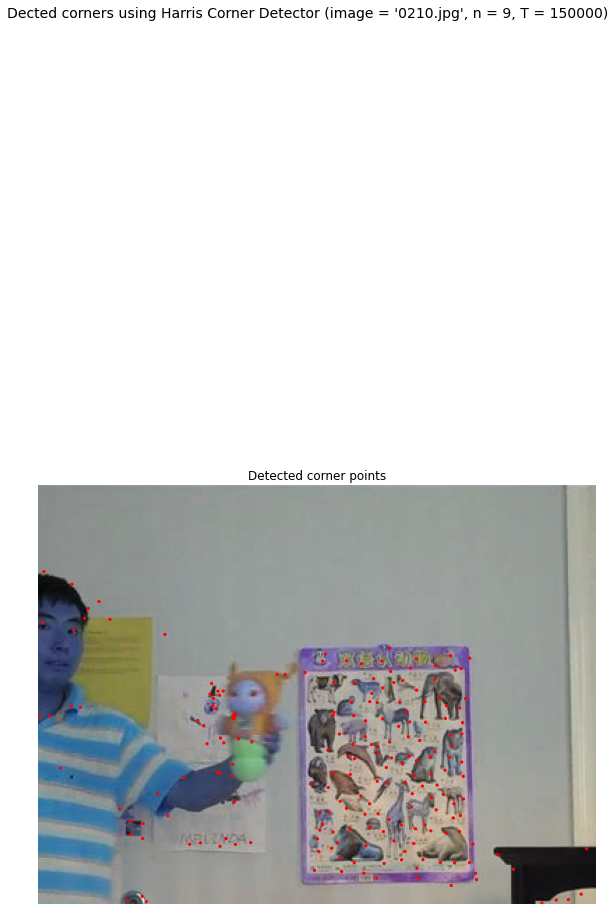

11  =  0210.jpg
168
4
164 : 173
[[  0.   0.   0.   0.  81.  77.  75.  77.  82.]
 [  0.   0.   0.   0.  84.  84.  85.  85.  85.]
 [  0.   0.   0.   0.  82.  84.  86.  85.  83.]
 [  0.   0.   0.   0.  82.  82.  82.  82.  82.]
 [  0.   0.   0.   0.  85.  84.  85.  87.  88.]
 [  0.   0.   0.   0.  83.  85.  87.  89.  87.]
 [  0.   0.   0.   0.  81.  85.  87.  84.  79.]
 [  0.   0.   0.   0.  84.  88.  87.  79.  75.]
 [  0.   0.   0.   0.  87.  77.  73.  85. 108.]]
x =  0.4148172298960022 , y =  164.8201493099163
vx =  0.008253268905689231 , vy =  -0.042879256926242525
x_new =  0.49734991895289454 , y_new =  164.3913567406539


65
7
61 : 70
[[  0. 148. 144. 142. 143. 142. 141. 142. 145.]
 [  0. 140. 140. 139. 136. 136. 138. 139. 138.]
 [  0. 136. 141. 143. 141. 142. 145. 144. 140.]
 [  0. 138. 141. 142. 141. 141. 143. 143. 141.]
 [  0. 144. 140. 138. 138. 138. 138. 140. 144.]
 [  0. 138. 132. 134. 145. 146. 139. 139. 146.]
 [  0. 103. 100. 112. 133. 138. 124. 118. 125.]
 [  0.  22.  30.  57

vx =  0.054725804705566615 , vy =  0.0723997900918262
x_new =  204.20747310452745 , y_new =  126.16633608766209


238
205
234 : 243
[[171. 178. 176. 171. 168. 164. 170. 171. 168.]
 [157. 156. 158. 169. 177. 173. 168. 162. 162.]
 [157.  98. 130. 160. 156. 131. 122. 137. 123.]
 [156.  84.  92.  98.  83.  78.  97. 122.  87.]
 [162.  94.  82. 106.  92. 104. 129. 155. 109.]
 [163. 113.  92. 110. 112. 131. 135. 149. 113.]
 [161. 119.  81.  91. 103. 123. 120. 117.  94.]
 [173. 131.  72. 105. 112. 124. 131. 114. 100.]
 [181. 151.  90. 114. 121. 113. 120.  99. 114.]]
x =  201.58785948340733 , y =  234.50423805137103
vx =  -0.006918321290358895 , vy =  0.08751052560205333
x_new =  201.51867627050373 , y_new =  235.37934330739157


257
204
253 : 262
[[175. 171. 171. 171. 167. 165. 160. 162. 162.]
 [165. 145. 145. 156. 170. 167. 162. 165. 168.]
 [142. 103.  99. 116. 160. 169. 169. 165. 167.]
 [130.  86.  80.  96. 144. 170. 175. 160. 159.]
 [135. 105. 101. 108. 141. 172. 179. 162. 157.]
 [139. 132.

x =  277.02323126457577 , y =  242.8742458457968
vx =  -0.008465317996028236 , vy =  0.05214823984892486
x_new =  276.9385780846155 , y_new =  243.39572824428603


271
279
267 : 276
[[141.  77.  65.  95. 116.  58.  61.  98. 113.]
 [164.  66.  43. 110. 112.  50.  54.  63.  53.]
 [173.  95.  37.  74.  93.  56.  45.  39.  38.]
 [179. 171. 112. 126. 144. 122.  94.  63.  57.]
 [176. 186. 171. 184. 186. 181. 174. 150. 142.]
 [172. 165. 174. 178. 167. 172. 184. 181. 182.]
 [170. 170. 174. 169. 165. 169. 168. 162. 165.]
 [164. 160. 167. 169. 177. 183. 176. 171. 170.]
 [155. 147. 163. 166. 164. 163. 166. 175. 172.]]
x =  275.5867105306962 , y =  267.7616702671106
vx =  -0.014851954553796103 , vy =  0.09737195459225935
x_new =  275.43819098515826 , y_new =  268.73538981303324


173
281
169 : 178
[[152.  47.  48. 140. 173. 177. 175. 175. 170.]
 [147.  55.  40. 114. 156. 167. 167. 170. 167.]
 [173. 117.  97. 145. 176. 177. 174. 176. 174.]
 [173. 173. 175. 174. 169. 165. 165. 172. 167.]
 [171. 175.

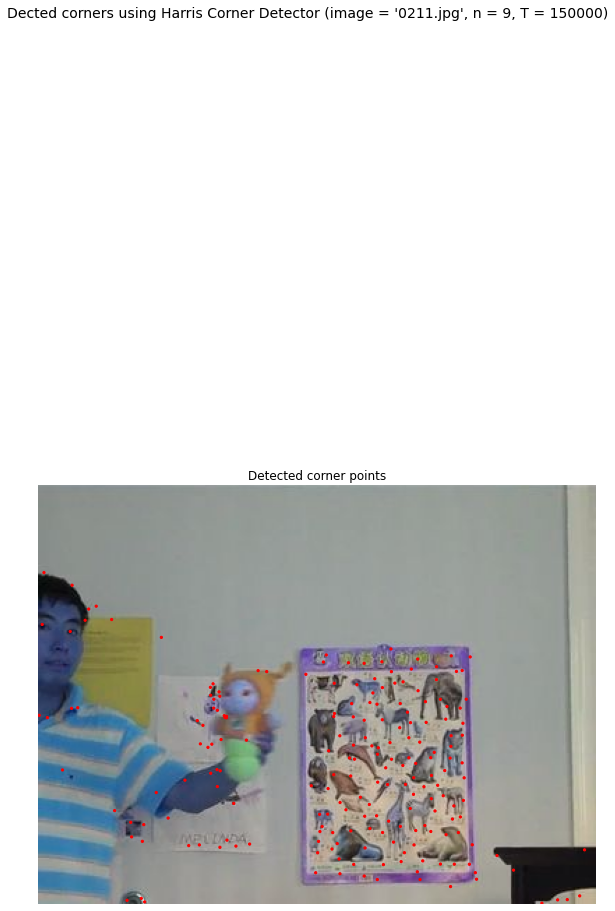

12  =  0211.jpg
168
4
164 : 173
[[  0.   0.   0.   0.  80.  80.  78.  75.  72.]
 [  0.   0.   0.   0.  76.  77.  78.  78.  78.]
 [  0.   0.   0.   0.  81.  79.  77.  75.  75.]
 [  0.   0.   0.   0.  85.  81.  77.  74.  74.]
 [  0.   0.   0.   0.  81.  80.  80.  81.  81.]
 [  0.   0.   0.   0.  77.  81.  84.  85.  83.]
 [  0.   0.   0.   0.  80.  82.  83.  80.  76.]
 [  0.   0.   0.   0.  83.  82.  79.  74.  74.]
 [  0.   0.   0.   0.  93.  74.  70.  89. 109.]]
x =  0.49734991895289454 , y =  164.3913567406539
vx =  0.011733457329391805 , vy =  0.07324085112585155
x_new =  0.6146844922468127 , y_new =  165.1237652519124


66
7
62 : 71
[[  0. 141. 139. 138. 136. 135. 135. 136. 137.]
 [  0. 139. 140. 142. 143. 143. 141. 140. 139.]
 [  0. 140. 140. 140. 140. 140. 140. 139. 138.]
 [  0. 142. 140. 137. 135. 135. 136. 138. 139.]
 [  0. 134. 136. 139. 141. 143. 143. 143. 142.]
 [  0. 102. 110. 122. 132. 137. 135. 129. 124.]
 [  0.  30.  37.  65.  91.  77.  45.  48.  78.]
 [  0.  14.  17.  28. 

x =  133.12190980987893 , y =  164.6391612873935
vx =  -0.7470102675457788 , vy =  -0.11144137533775841
x_new =  125.65180713442115 , y_new =  163.52474753401592


209
127
205 : 214
[[152. 162. 169. 164. 133.  90.  64.  63.  74.]
 [159. 133. 114.  90.  75.  72.  74.  74.  72.]
 [ 99.  84.  74.  66.  68.  77.  84.  83.  79.]
 [ 69.  69.  75.  82.  82.  78.  74.  74.  76.]
 [ 82.  75.  72.  70.  74.  80.  83.  80.  77.]
 [ 63.  76.  79.  80.  76.  70.  69.  74.  80.]
 [ 86.  79.  75.  72.  75.  80.  81.  75.  69.]
 [ 75.  73.  73.  74.  75.  76.  77.  77.  78.]
 [ 75.  73.  74.  74.  75.  76.  77.  77.  78.]]
x =  123.4554755930757 , y =  205.9144283090241
vx =  0.22690264692285447 , vy =  0.10085794606672466
x_new =  125.72450206230425 , y_new =  206.92300776969134


145
129
141 : 150
[[167. 164. 162. 160. 160. 163. 164. 165. 163.]
 [169. 169. 167. 165. 166. 170. 174. 173. 165.]
 [163. 166. 167. 164. 163. 165. 168. 167. 160.]
 [165. 166. 165. 162. 161. 162. 164. 166. 160.]
 [167. 165. 1

238
180 : 189
[[115.  75.  99. 112. 110. 134. 166. 184. 163.]
 [147.  98.  98. 111. 103. 143. 174. 174. 155.]
 [164. 102. 102. 119.  98. 153. 183. 165. 156.]
 [172. 113. 105. 134. 101. 158. 187. 166. 172.]
 [169. 124. 102. 142. 105. 158. 186. 172. 186.]
 [136.  94. 106. 142. 103. 151. 183. 176. 185.]
 [119.  95. 136. 146.  97. 139. 177. 176. 179.]
 [144. 154. 169. 153.  91. 129. 171. 174. 175.]
 [161. 169. 166. 175. 170. 160. 166. 176. 177.]]
x =  234.26234588883395 , y =  180.44045738593084
vx =  -0.18221849103923868 , vy =  0.15516443474094233
x_new =  232.44016097844155 , y_new =  181.99210173334026


171
237
167 : 176
[[148. 160. 164. 169. 175. 168. 160. 166. 171.]
 [130. 138. 144. 166. 175. 172. 168. 177. 184.]
 [131. 130. 131. 150. 163. 166. 166. 175. 179.]
 [153. 156. 159. 158. 170. 172. 169. 175. 179.]
 [153. 152. 154. 161. 171. 168. 162. 169. 176.]
 [134. 137. 139. 140. 142. 166. 170. 166. 172.]
 [132. 130. 129. 132. 127. 148. 164. 172. 176.]
 [133. 130. 129. 131. 115. 127. 14

x =  269.1768533542882 , y =  257.3030272323
vx =  -0.17469906690593134 , vy =  0.16962606183252113
x_new =  267.4298626852289 , y_new =  258.9992878506252


213
272
209 : 218
[[187. 178. 185. 134.  44.  80.  89. 113. 129.]
 [105. 126. 171. 142.  55.  82. 103. 101. 108.]
 [ 90.  45.  74. 113.  79.  71. 106. 108.  93.]
 [179. 137.  62.  58.  87. 108.  87.  88. 113.]
 [178. 187. 142.  57.  70. 112.  94.  84.  90.]
 [165. 179. 178.  63.  41.  88. 101.  89.  87.]
 [184. 162. 177. 119.  52.  49.  64.  47.  47.]
 [171. 178. 173. 180. 131.  90.  73.  51.  30.]
 [112. 192. 168. 182. 195. 180. 153. 143. 116.]]
x =  268.9547638953027 , y =  209.11535880559347
vx =  -0.09795333287896549 , vy =  0.15358842383573618
x_new =  267.975230566513 , y_new =  210.65124304395084


150
276
146 : 155
[[172. 169. 164. 164. 160. 175. 176. 165. 174.]
 [154. 157. 160. 175. 169. 172. 168. 161. 172.]
 [ 71.  95. 153. 179. 164. 167. 163. 173. 142.]
 [100.  95. 137. 168. 167. 171. 170. 166. 119.]
 [142. 118. 139. 16

x =  328.6680645062007 , y =  264.96018386116293
vx =  -0.06027684280721653 , vy =  0.248274203078097
x_new =  328.06529607812854 , y_new =  267.4429258919439


279
344
275 : 284
[[ 40.  47.  49.  39.  29.  27.  28.  29.  29.]
 [154. 155. 152.  56.  18.  31.  24.  23.  25.]
 [158. 159. 156.  59.  20.  32.  25.  23.  25.]
 [160. 161. 158.  61.  21.  31.  24.  23.  25.]
 [157. 159. 158.  61.  20.  30.  23.  22.  25.]
 [155. 158. 158.  61.  20.  30.  24.  23.  26.]
 [154. 159. 160.  63.  22.  31.  25.  25.  25.]
 [154. 160. 161.  64.  21.  29.  22.  22.  23.]
 [154. 159. 160.  62.  18.  25.  18.  18.  20.]]
x =  340.5197349561876 , y =  275.36766642040084
vx =  -0.10210187358057565 , vy =  0.239602017380028
x_new =  339.4987162203819 , y_new =  277.7636865942011


303
364
299 : 308
Out of bounds
300
376
296 : 305
[[ 10.  23.  25.  15.  22.  61. 110. 141. 162.]
 [ 37.   6.   6.  64. 135. 169. 168. 160. 164.]
 [  3.  33.  94. 151. 166. 151. 148. 163. 148.]
 [ 26. 104. 162. 158. 146. 157. 15

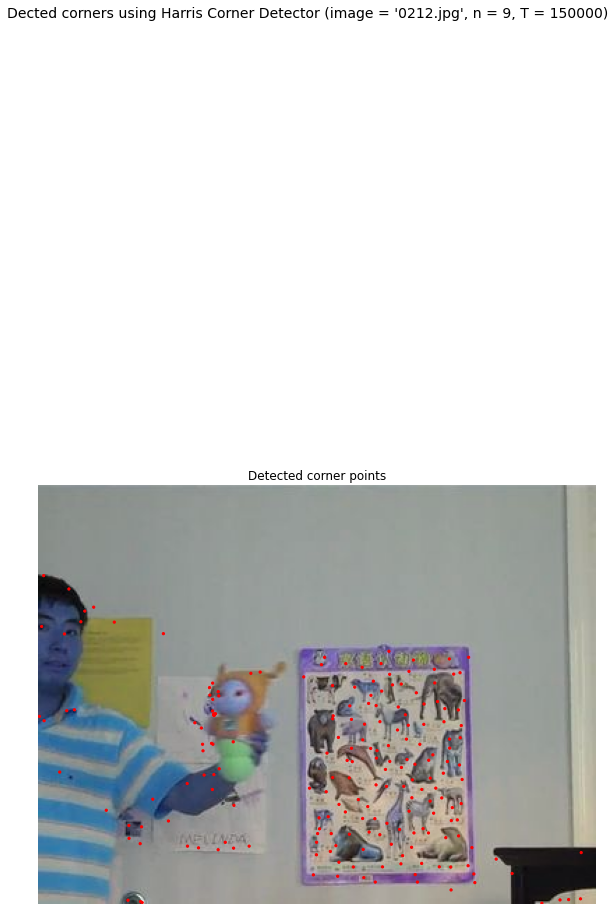

13  =  0212.jpg
169
4
165 : 174
[[  0.   0.   0.   0.  73.  75.  77.  78.  78.]
 [  0.   0.   0.   0.  78.  80.  81.  79.  76.]
 [  0.   0.   0.   0.  84.  83.  80.  77.  75.]
 [  0.   0.   0.   0.  79.  77.  76.  78.  79.]
 [  0.   0.   0.   0.  77.  78.  80.  82.  82.]
 [  0.   0.   0.   0.  81.  83.  84.  82.  78.]
 [  0.   0.   0.   0.  79.  82.  81.  76.  73.]
 [  0.   0.   0.   0.  85.  77.  75.  88. 109.]
 [  0.   0.   0.   0.  71.  83. 101. 115. 121.]]
x =  0.6146844922468127 , y =  165.1237652519124
vx =  -0.0027924938563344166 , vy =  0.06864850816844836
x_new =  0.5867595536834684 , y_new =  165.81025033359688


68
7
64 : 73
[[  0. 139. 139. 139. 139. 139. 139. 139. 139.]
 [  0. 138. 138. 139. 139. 139. 140. 140. 140.]
 [  0. 137. 137. 138. 139. 140. 140. 141. 141.]
 [  0. 136. 137. 138. 139. 140. 141. 142. 142.]
 [  0.  51.  78. 105. 103.  78.  66.  89. 120.]
 [  0.  13.  27.  41.  40.  26.  20.  34.  54.]
 [  0.  15.  15.  16.  17.  15.  14.  18.  24.]
 [  0.  23.  18.  14

x =  125.6554693093307 , y =  164.14746976148095
vx =  -0.14492994087169467 , vy =  0.028786064205538545
x_new =  124.20616990061374 , y_new =  164.43533040353634


167
129
163 : 172
[[138.  97.  50.  99. 150. 119. 117. 112. 114.]
 [123. 109.  49.  55. 112. 113. 115. 106. 108.]
 [116. 111.  49.  47. 110. 125. 124. 107. 106.]
 [ 98. 112.  84.  81. 125. 133. 125. 116. 109.]
 [ 84. 102. 118. 121. 136. 133. 126. 129. 113.]
 [118. 119. 136. 137. 145. 153. 154. 150. 132.]
 [152. 144. 137. 127. 137. 150. 148. 138. 128.]
 [146. 133. 120. 109. 106. 107. 100.  96.  94.]
 [146. 121. 117. 115.  97.  86.  83.  85.  86.]]
x =  125.93560120352714 , y =  163.75982910154835
vx =  -0.054178458385485725 , vy =  0.047076586804311274
x_new =  125.39381661967228 , y_new =  164.23059496959146


168
129
164 : 173
[[123. 109.  49.  55. 112. 113. 115. 106. 108.]
 [116. 111.  49.  47. 110. 125. 124. 107. 106.]
 [ 98. 112.  84.  81. 125. 133. 125. 116. 109.]
 [ 84. 102. 118. 121. 136. 133. 126. 129. 113.]
 [118. 

vx =  0.21026391332184838 , vy =  0.10532295793255364
x_new =  242.11924175732523 , y_new =  140.93503975677882


161
246
157 : 166
[[167. 155. 141. 154. 138. 128. 155. 183. 168.]
 [168. 179. 165. 167. 141. 139. 176. 178. 172.]
 [168. 173. 170. 173. 151. 150. 178. 154. 166.]
 [164. 166. 175. 171. 144. 138. 156. 125. 147.]
 [167. 179. 178. 165. 138. 139. 153. 125. 126.]
 [165. 175. 177. 161. 141. 150. 161. 143. 115.]
 [165. 161. 181. 161. 142. 148. 152. 148. 116.]
 [163. 169. 179. 158. 145. 123. 111. 108. 110.]
 [169. 173. 171. 168. 143.  89. 118.  99. 102.]]
x =  242.01044561124263 , y =  157.41840888864436
vx =  0.26999060951430026 , vy =  -0.0028069534316660025
x_new =  244.71035170638564 , y_new =  157.3903393543277


131
249
127 : 136
[[108. 133. 119. 114. 152. 103. 133. 111. 114.]
 [119. 133. 108.  99. 171. 131. 129. 109. 107.]
 [107. 115. 121. 106. 165. 131. 106. 116. 131.]
 [ 75.  83. 123. 115. 151. 131. 102. 133. 153.]
 [110.  91. 128. 130. 159. 143. 106. 143. 156.]
 [ 95. 101.

x =  296.626431786579 , y =  230.55959963637676
vx =  0.24742362502233645 , vy =  -0.09323591127027797
x_new =  299.1006680368024 , y_new =  229.62724052367398


277
299
273 : 282
[[ 96. 107. 101. 116. 107.  90.  80.  71.  64.]
 [171. 169. 166. 168. 164. 168. 144. 145. 162.]
 [160. 160. 175. 172. 187. 183. 173. 172. 167.]
 [172. 171. 157. 150. 154. 143. 171. 167. 146.]
 [168. 165. 141. 119. 112. 151. 172. 168. 153.]
 [189. 193. 176. 154. 143. 171. 180. 176. 167.]
 [169. 179. 175. 167. 164. 177. 178. 175. 173.]
 [179. 182. 180. 180. 183. 181. 178. 179. 184.]
 [168. 167. 162. 163. 168. 173. 167. 169. 170.]]
x =  295.5152683805448 , y =  273.1495554556245
vx =  0.19121521296472443 , vy =  -0.01969440791174735
x_new =  297.42742051019206 , y_new =  272.95261137650704


164
304
160 : 169
[[ 68.  88. 106.  81.  59.  75. 100. 166. 152.]
 [ 75.  83.  95.  58.  57.  88. 119. 159. 148.]
 [ 71.  80. 109.  39.  67.  97. 145. 154. 144.]
 [ 59.  88. 144.  36.  79. 106. 171. 154. 142.]
 [ 64. 110. 14

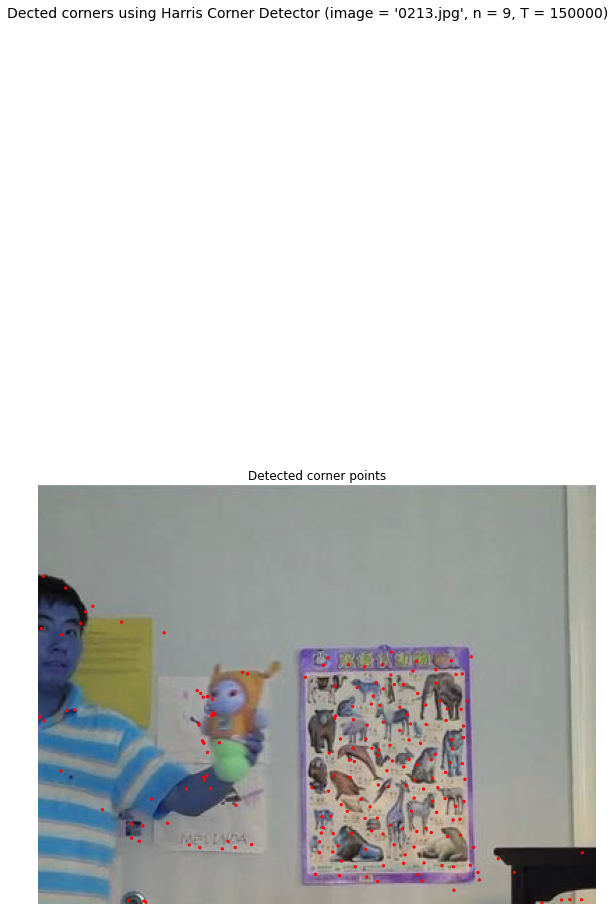

14  =  0213.jpg
169
4
165 : 174
[[  0.   0.   0.   0.  75.  78.  79.  77.  77.]
 [  0.   0.   0.   0.  79.  80.  78.  77.  78.]
 [  0.   0.   0.   0.  83.  82.  78.  75.  76.]
 [  0.   0.   0.   0.  81.  82.  80.  77.  76.]
 [  0.   0.   0.   0.  77.  81.  83.  81.  78.]
 [  0.   0.   0.   0.  77.  82.  83.  79.  77.]
 [  0.   0.   0.   0.  82.  83.  79.  73.  74.]
 [  0.   0.   0.   0.  81.  80.  80.  86. 100.]
 [  0.   0.   0.   0.  75.  86. 100. 110. 118.]]
x =  0.5867595536834684 , y =  165.81025033359688
vx =  0.0002178132243495978 , vy =  -0.06466291608512109
x_new =  0.5889376859269644 , y_new =  165.16362117274568


68
7
64 : 73
[[  0. 140. 140. 140. 140. 139. 139. 138. 138.]
 [  0. 139. 139. 140. 140. 140. 139. 139. 138.]
 [  0. 138. 138. 139. 140. 140. 140. 139. 139.]
 [  0. 137. 138. 139. 140. 141. 140. 140. 139.]
 [  0.  58.  82. 112. 114.  82.  61.  88. 134.]
 [  0.  17.  29.  46.  48.  29.  16.  34.  62.]
 [  0.  16.  16.  18.  19.  16.  14.  18.  25.]
 [  0.  21.  19.  1

x =  124.7438594936229 , y =  164.5215287020606
vx =  -0.21561546134522608 , vy =  0.07809388336279248
x_new =  122.58770488017065 , y_new =  165.30246753568852


154
125
150 : 159
[[163. 164. 165. 163. 145. 117.  98.  99. 112.]
 [162. 163. 164. 161. 144. 117.  95.  91. 100.]
 [161. 162. 163. 160. 145. 120.  96.  83.  84.]
 [160. 161. 162. 165. 147. 122.  98.  75.  63.]
 [159. 160. 161. 166. 143. 118. 100.  77.  57.]
 [159. 160. 160. 159. 133. 112. 105.  89.  71.]
 [165. 166. 158. 159. 139. 119. 118. 125. 119.]
 [164. 165. 157. 163. 144. 131. 130. 134. 136.]
 [165. 166. 157. 154. 132. 126. 128. 124. 131.]]
x =  121.26810235338125 , y =  150.86360855522204
vx =  -0.786085154825416 , vy =  -0.343076077000341
x_new =  113.40725080512709 , y_new =  147.43284778521863


186
121
182 : 191
[[158. 159. 160. 154. 138. 122. 113.  91.  86.]
 [156. 157. 161. 161. 155. 143. 135. 119. 112.]
 [155. 155. 159. 163. 165. 160. 155. 161. 149.]
 [156. 156. 156. 160. 165. 164. 161. 171. 157.]
 [158. 159. 15

x =  239.01685526731544 , y =  187.95524990797787
vx =  0.14560643387343603 , vy =  -0.08076014363756194
x_new =  240.4729196060498 , y_new =  187.14764847160225


233
241
229 : 238
[[102. 101. 123. 159. 185. 187. 176. 186. 128.]
 [160. 131. 109. 122. 160. 185. 187. 152. 111.]
 [178. 176. 156. 150. 167. 184. 187. 138. 144.]
 [167. 172. 174. 178. 182. 179. 172. 180. 183.]
 [173. 167. 169. 172. 173. 174. 175. 189. 197.]
 [165. 176. 180. 176. 173. 176. 183. 171. 190.]
 [172. 172. 164. 159. 163. 172. 178. 186. 178.]
 [177. 175. 177. 148. 124. 161. 176. 175. 154.]
 [156. 177. 182. 160. 148. 180. 181. 160. 138.]]
x =  237.671699502105 , y =  229.98679171355857
vx =  0.1569199995343109 , vy =  -0.11071677080112341
x_new =  239.2408994974481 , y_new =  228.87962400554733


251
242
247 : 256
[[172. 117.  62.  83.  93. 114. 109. 111. 105.]
 [171. 155. 110. 132. 108. 124. 140. 135. 123.]
 [171. 153.  94.  80.  53.  84. 101. 100. 102.]
 [151. 110.  77.  51.  71. 124.  83.  89. 112.]
 [159. 131. 15

 [173. 161. 171. 172. 142. 134. 110. 113.  66.]]
x =  271.8327482758361 , y =  148.72550927386607
vx =  0.15853406412744264 , vy =  -0.08903287195518086
x_new =  273.4180889171105 , y_new =  147.83518055431426


203
275
199 : 208
[[152. 150. 156. 193. 183. 126.  77.  49.  72.]
 [184. 172. 173. 185. 148.  67.  58.  64.  91.]
 [171. 178. 197. 166.  90.  56.  70.  90. 108.]
 [161. 186. 197. 132.  62.  76.  81.  94. 112.]
 [180. 192. 166.  93.  73.  91.  77.  80. 106.]
 [175. 192. 144.  63.  72.  84. 103.  89. 109.]
 [168. 179. 108.  62.  85.  93. 105. 111. 113.]
 [183. 183.  88.  64.  83. 102. 113. 142. 125.]
 [184. 160.  77.  68.  80. 100. 109. 137. 121.]]
x =  271.5793501565312 , y =  199.79389664100736
vx =  0.12591920264513667 , vy =  -0.011211754159816206
x_new =  272.83854218298256 , y_new =  199.6817790994092


251
275
247 : 256
[[138.  92. 166. 186. 169. 170. 168. 170. 154.]
 [128.  98. 123. 186. 170. 175. 160. 175. 154.]
 [ 99. 139.  88. 157. 175. 175. 162. 183. 151.]
 [101. 159.

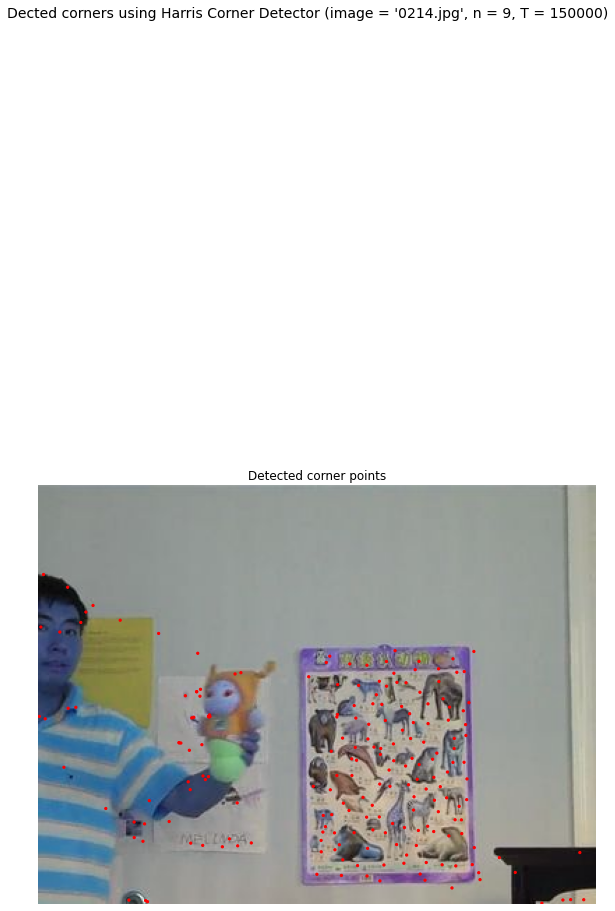

15  =  0214.jpg
169
4
165 : 174
[[  0.   0.   0.   0.  78.  79.  77.  74.  74.]
 [  0.   0.   0.   0.  81.  81.  77.  73.  74.]
 [  0.   0.   0.   0.  80.  80.  79.  77.  78.]
 [  0.   0.   0.   0.  77.  80.  81.  80.  80.]
 [  0.   0.   0.   0.  78.  81.  82.  80.  78.]
 [  0.   0.   0.   0.  80.  82.  81.  77.  77.]
 [  0.   0.   0.   0.  81.  83.  80.  74.  77.]
 [  0.   0.   0.   0.  87.  77.  75.  88. 107.]
 [  0.   0.   0.   0.  70.  83. 100. 111. 115.]]
x =  0.5889376859269644 , y =  165.16362117274568
vx =  0.008879345309079275 , vy =  -0.040121089201304014
x_new =  0.6777311390177572 , y_new =  164.76241028073264


67
7
63 : 72
[[  0. 140. 139. 138. 138. 138. 139. 140. 141.]
 [  0. 143. 139. 136. 137. 140. 142. 141. 139.]
 [  0. 142. 140. 138. 139. 141. 143. 142. 141.]
 [  0. 134. 137. 141. 140. 138. 137. 139. 142.]
 [  0. 124. 134. 142. 140. 132. 129. 135. 143.]
 [  0.  46.  78. 103.  91.  54.  41.  76. 122.]
 [  0.  20.  30.  40.  36.  20.  15.  31.  53.]
 [  0.  21.  18.  1

 [154. 156. 157. 158. 158. 156. 154. 146. 137.]]
x =  117.11672327409815 , y =  185.45450405397804
vx =  -1.1707572106074933 , vy =  -0.6653463798160425
x_new =  105.40915116802321 , y_new =  178.8010402558176


219
200
215 : 224
[[168. 173. 176. 189. 175. 144.  76.  27.  41.]
 [155. 184. 175. 127. 122. 105.  75.  46.  60.]
 [140. 198. 151.  47.  65.  70.  76. 103. 110.]
 [154. 201. 155.  64.  53.  70.  90. 120. 122.]
 [155. 183. 186. 137.  49.  51.  67.  62.  81.]
 [160. 185. 184. 175.  99.  30.  20.  55.  52.]
 [146. 181. 185. 192. 160. 122.  86.  69. 110.]
 [157. 187. 174. 172. 169. 172. 133.  87. 106.]
 [152. 186. 175. 173. 169. 172. 136.  92.  86.]]
x =  196.9882429230009 , y =  215.28274840901784
vx =  0.11083638103840279 , vy =  0.042173438701376534
x_new =  198.09660673338493 , y_new =  215.7044827960316


282
203
278 : 287
[[154. 130. 118. 146. 178. 162. 140. 152. 147.]
 [155. 139. 133. 155. 172. 175. 161. 171. 164.]
 [170. 164. 161. 174. 175. 169. 148. 144. 143.]
 [177. 172. 

 [167. 144. 139. 150. 151. 138. 147. 166. 173.]]
x =  254.40487248467113 , y =  184.89673339339546
vx =  0.13808821971753268 , vy =  0.10697089613721848
x_new =  255.78575468184647 , y_new =  185.96644235476765


245
257
241 : 250
[[179. 107. 118. 143. 134. 142. 135. 161. 133.]
 [165. 101. 127. 150. 137. 126. 122. 140. 146.]
 [158. 115. 137. 147. 144. 139. 164. 145. 135.]
 [156. 111. 127. 151. 156. 130. 150. 130. 117.]
 [151. 104. 118. 132. 146. 112. 101. 129. 107.]
 [160. 120. 126. 120. 142. 118. 103. 135. 122.]
 [160. 115. 109. 110. 135. 115. 111. 152. 106.]
 [168. 108.  89. 121. 136. 103.  93. 117.  93.]
 [177. 138.  96. 127. 132. 110.  89.  89. 101.]]
x =  253.8067660033445 , y =  241.93924651370205
vx =  0.1486606396505295 , vy =  0.12535119475154097
x_new =  255.2933723998498 , y_new =  243.19275846121747


122
259
118 : 127
[[153. 169. 167. 158. 154. 154. 161. 161. 160.]
 [102. 137. 163. 170. 166. 166. 170. 167. 167.]
 [ 91.  99. 121. 142. 146. 137. 136. 130. 130.]
 [104.  97. 1

x =  304.51291525736315 , y =  161.15827848110598
vx =  0.12876819951002647 , vy =  0.030839466366698265
x_new =  305.80059725246343 , y_new =  161.46667314477295


243
307
239 : 248
[[ 97. 122. 129. 100.  82. 156. 167. 178. 186.]
 [153. 159. 176. 160. 168. 168. 169. 173. 183.]
 [176. 167. 172. 162. 166. 169. 164. 165. 179.]
 [171. 168. 166. 171. 165. 162. 157. 161. 180.]
 [184. 167. 150. 174. 173. 154. 152. 161. 183.]
 [179. 159. 148. 160. 174. 145. 149. 174. 179.]
 [179. 174. 164. 158. 152. 147. 150. 171. 177.]
 [169. 167. 161. 153. 142. 154. 155. 170. 175.]
 [184. 177. 173. 172. 165. 164. 164. 170. 176.]]
x =  303.1076863109962 , y =  239.34929705820596
vx =  0.15781125040129218 , vy =  0.07293860403348747
x_new =  304.68579881500915 , y_new =  240.07868309854084


202
309
198 : 207
[[109. 149. 130. 170. 171. 177. 139.  94. 100.]
 [117. 152. 132. 174. 172. 177. 140.  96.  99.]
 [125. 144. 139. 178. 173. 178. 145. 101. 100.]
 [123. 136. 150. 182. 174. 179. 149. 105. 101.]
 [113. 135.

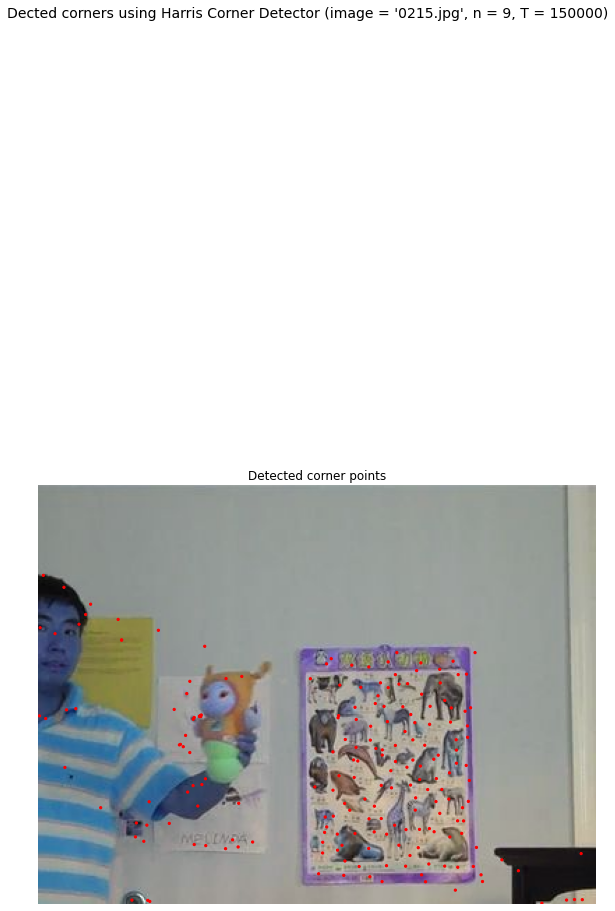

16  =  0215.jpg
168
4
164 : 173
[[  0.   0.   0.   0.  73.  75.  78.  78.  77.]
 [  0.   0.   0.   0.  75.  76.  77.  77.  77.]
 [  0.   0.   0.   0.  77.  77.  76.  77.  77.]
 [  0.   0.   0.   0.  78.  77.  76.  77.  78.]
 [  0.   0.   0.   0.  79.  78.  77.  76.  75.]
 [  0.   0.   0.   0.  81.  81.  78.  75.  71.]
 [  0.   0.   0.   0.  82.  81.  79.  74.  72.]
 [  0.   0.   0.   0.  80.  81.  79.  75.  76.]
 [  0.   0.   0.   0.  79.  72.  74.  89. 108.]]
x =  0.6777311390177572 , y =  164.76241028073264
vx =  0.0031266532826402073 , vy =  0.3528818321169054
x_new =  0.7089976718441593 , y_new =  168.29122860190168


68
7
64 : 73
[[  0. 140. 139. 138. 140. 141. 140. 140. 140.]
 [  0. 143. 139. 138. 141. 143. 142. 141. 141.]
 [  0. 140. 137. 138. 141. 141. 138. 138. 142.]
 [  0. 134. 134. 137. 139. 136. 131. 134. 141.]
 [  0.  55.  93. 119.  97.  56.  49.  88. 130.]
 [  0.  21.  36.  44.  33.  19.  20.  38.  55.]
 [  0.  21.  19.  14.  13.  18.  25.  25.  21.]
 [  0.  19.  20.  19.

vx =  -0.05407730701224282 , vy =  0.21467445556077802
x_new =  113.63876711247849 , y_new =  231.55828928512932


169
119
165 : 174
[[166. 159. 151. 157. 162. 150. 125. 108. 112.]
 [162. 166. 157. 156. 164. 160. 137. 116. 108.]
 [165. 161. 165. 157. 156. 159. 153. 133. 101.]
 [166. 156. 166. 154. 156. 164. 162. 148. 110.]
 [143. 174. 170. 146. 154. 163. 158. 165. 148.]
 [102. 157. 159. 131. 136. 141. 140. 161. 150.]
 [ 74.  98. 129. 115. 115. 117. 120. 133. 101.]
 [ 66.  85. 112. 123. 104.  89.  91.  90.  81.]
 [124. 111. 117. 115. 103.  93.  89.  89.  87.]]
x =  115.49281392072898 , y =  165.0224869055971
vx =  -0.2321973636698455 , vy =  -0.0025721103406940865
x_new =  113.17084028403052 , y_new =  164.99676580219017


169
119
165 : 174
[[166. 159. 151. 157. 162. 150. 125. 108. 112.]
 [162. 166. 157. 156. 164. 160. 137. 116. 108.]
 [165. 161. 165. 157. 156. 159. 153. 133. 101.]
 [166. 156. 166. 154. 156. 164. 162. 148. 110.]
 [143. 174. 170. 146. 154. 163. 158. 165. 148.]
 [102. 157

x =  264.0990794600863 , y =  201.5829744585552
vx =  0.3809178090648559 , vy =  0.07406077595507482
x_new =  267.90825755073485 , y_new =  202.32358221810597


145
268
141 : 150
[[138. 167. 161. 165. 160. 165. 163. 159. 176.]
 [101. 168. 164. 164. 173. 171. 167. 161. 168.]
 [ 97. 148. 156. 167. 167. 164. 163. 157. 161.]
 [140. 134. 144. 160. 173. 167. 167. 159. 166.]
 [153. 150. 160. 143. 143. 155. 176. 171. 167.]
 [129. 156. 160. 124.  89. 110. 156. 174. 171.]
 [117. 133. 122. 110. 122. 102. 119. 147. 167.]
 [134. 119. 106.  99.  87.  86.  78.  77.  96.]
 [155. 141. 132. 130. 127. 122. 116. 108.  87.]]
x =  264.5619876992567 , y =  141.73800229108903
vx =  0.4541053030671275 , vy =  0.059790638747767674
x_new =  269.10304072992795 , y_new =  142.3359086785667


250
267
246 : 255
[[ 40.  84. 122. 132. 160. 173. 170. 118. 126.]
 [ 73. 146. 144. 134. 166. 179. 165. 130. 114.]
 [ 93. 173. 140. 119. 159. 180. 170. 138.  93.]
 [ 96. 161. 134. 120. 162. 169. 174. 137.  81.]
 [ 85. 133. 132.

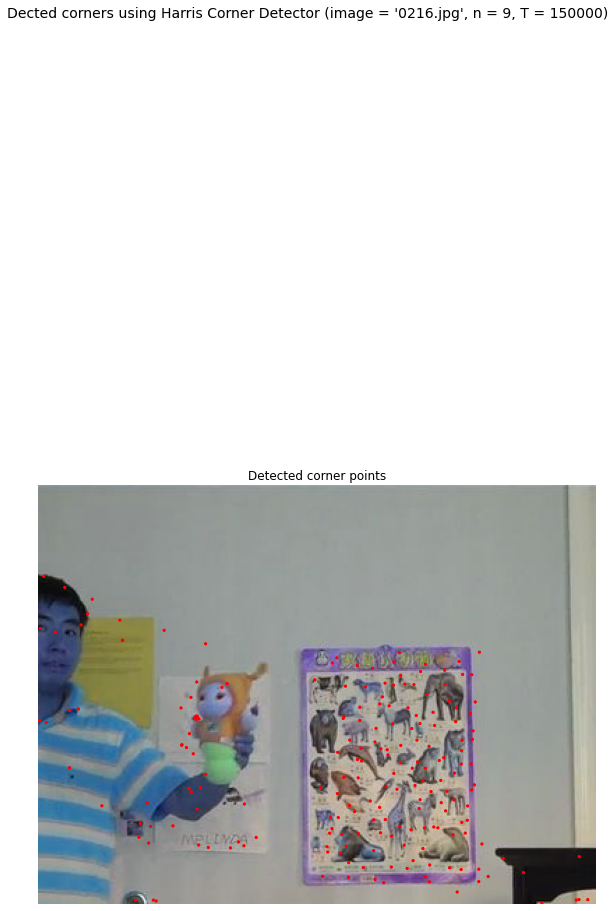

17  =  0216.jpg
172
4
168 : 177
[[  0.   0.   0.   0.  81.  78.  76.  76.  78.]
 [  0.   0.   0.   0.  81.  79.  78.  78.  77.]
 [  0.   0.   0.   0.  81.  82.  80.  75.  70.]
 [  0.   0.   0.   0.  80.  81.  80.  73.  69.]
 [  0.   0.   0.   0.  76.  76.  74.  77.  90.]
 [  0.   0.   0.   0.  73.  78.  87. 102. 119.]
 [  0.   0.   0.   0.  75.  92. 110. 118. 119.]
 [  0.   0.   0.   0.  95. 111. 123. 121. 113.]
 [  0.   0.   0.   0. 118. 119. 120. 121. 124.]]
x =  0.7089976718441593 , y =  168.29122860190168
vx =  0.0064940016577220445 , vy =  0.37160289767084653
x_new =  0.7739376884213798 , y_new =  172.00725757861014


68
7
64 : 73
[[  0. 138. 139. 139. 139. 139. 139. 138. 138.]
 [  0. 137. 138. 138. 139. 139. 139. 138. 138.]
 [  0. 137. 138. 139. 139. 140. 140. 140. 140.]
 [  0. 138. 138. 139. 140. 141. 141. 141. 141.]
 [  0.  57.  88. 120. 118.  81.  58.  86. 132.]
 [  0.  15.  26.  40.  41.  27.  18.  31.  53.]
 [  0.  20.  20.  19.  19.  22.  25.  27.  28.]
 [  0.  17.  21.  20



148
135
144 : 153
[[ 93. 105. 103. 100.  97.  98. 102. 109. 114.]
 [115. 119. 116. 111. 105. 100.  99. 100. 103.]
 [143. 138. 137. 132. 124. 114. 105.  99.  96.]
 [148. 152. 152. 149. 142. 129. 115. 103.  97.]
 [156. 155. 147. 150. 155. 148. 136. 116.  94.]
 [159. 136. 139. 149. 154. 150. 147. 137. 119.]
 [161. 155. 155. 160. 163. 162. 163. 153. 132.]
 [161. 178. 161. 155. 162. 168. 169. 157. 138.]
 [165. 156. 130. 123. 137. 146. 148. 150. 148.]]
x =  131.46206094586327 , y =  144.2947293814859
vx =  -0.5047167848073739 , vy =  0.5461727050938356
x_new =  126.41489309778953 , y_new =  149.75645643242424


249
214
245 : 254
[[168. 143. 130. 151. 161. 134. 150. 174. 173.]
 [160. 138. 148. 170. 171. 144. 137. 170. 173.]
 [157. 131. 163. 170. 159. 149. 136. 171. 174.]
 [184. 161. 165. 167. 157. 164. 155. 174. 176.]
 [167. 157. 157. 166. 160. 171. 168. 168. 172.]
 [130. 120. 158. 168. 150. 147. 166. 162. 172.]
 [150. 149. 171. 172. 134. 116. 159. 165. 179.]
 [167. 176. 164. 172. 139. 126.

x =  277.3183506164857 , y =  127.74690273558669
vx =  0.24096930153851226 , vy =  0.3272610608644678
x_new =  279.72804363187083 , y_new =  131.01951334423137


235
276
231 : 240
[[110. 138. 125. 114. 115. 129. 136. 142. 143.]
 [104. 142. 177. 151. 153. 148. 131. 119. 117.]
 [144. 139. 148. 184. 180. 176. 168. 153. 138.]
 [125. 139. 169. 156. 160. 161. 172. 169. 152.]
 [142. 142. 131. 167. 160. 150. 159. 157. 144.]
 [127. 155. 126. 149. 147. 148. 135. 154. 143.]
 [138. 145. 132. 131. 134. 132. 123. 140. 141.]
 [131. 123. 143. 132. 132. 124. 118. 126. 137.]
 [119. 100. 133. 134. 131. 119. 117. 116. 127.]]
x =  272.8538271153258 , y =  231.21441832321176
vx =  0.025622639355844384 , vy =  0.20266828972957143
x_new =  273.1100535088843 , y_new =  233.24110122050746


228
277
224 : 233
[[174. 160. 169. 160. 167. 165. 156. 154. 161.]
 [179. 171. 179. 174. 173. 170. 166. 166. 169.]
 [181. 182. 188. 183. 179. 176. 179. 182. 183.]
 [175. 181. 182. 179. 182. 181. 177. 180. 181.]
 [194. 180. 19

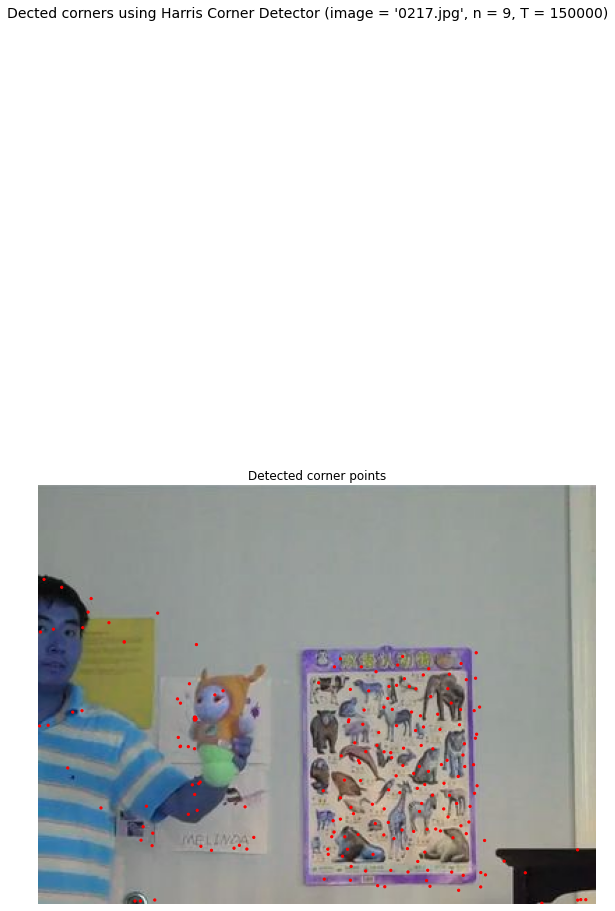

18  =  0217.jpg
176
4
172 : 181
[[  0.   0.   0.   0.  80.  86.  83.  73.  76.]
 [  0.   0.   0.   0.  81.  67.  67.  91. 116.]
 [  0.   0.   0.   0.  70.  73.  89. 114. 126.]
 [  0.   0.   0.   0.  74. 100. 121. 120. 112.]
 [  0.   0.   0.   0. 105. 115. 119. 114. 114.]
 [  0.   0.   0.   0. 127. 116. 111. 116. 118.]
 [  0.   0.   0.   0. 124. 118. 116. 118. 113.]
 [  0.   0.   0.   0. 117. 121. 118. 111. 115.]
 [  0.   0.   0.   0. 110. 115. 123. 130. 134.]]
x =  0.7739376884213798 , y =  172.00725757861014
vx =  -0.0026210563422942065 , vy =  -0.010269466492612372
x_new =  0.7477271249984377 , y_new =  171.904562913684


70
7
66 : 75
[[  0. 139. 140. 141. 140. 139. 138. 138. 139.]
 [  0. 139. 140. 141. 140. 139. 138. 138. 139.]
 [  0.  93. 113. 143. 150. 120.  91. 110. 152.]
 [  0.  22.  43.  69.  71.  42.  20.  42.  82.]
 [  0.  11.  14.  20.  22.  17.  13.  22.  36.]
 [  0.  22.  16.  10.  12.  20.  27.  26.  21.]
 [  0.  13.  19.  20.  15.  13.  17.  20.  19.]
 [  0.  17.  21.  2

248 : 257
[[145. 166. 170. 166. 169. 145. 162. 173. 171.]
 [164. 165. 166. 160. 171. 164. 167. 175. 171.]
 [130. 156. 162. 149. 149. 164. 163. 176. 169.]
 [130. 159. 169. 146. 127. 152. 151. 171. 162.]
 [169. 164. 172. 145. 107. 140. 170. 158. 180.]
 [140. 157. 170. 158. 131. 152. 173. 161. 176.]
 [143. 164. 166. 160. 144. 156. 171. 161. 162.]
 [163. 172. 163. 161. 160. 165. 167. 153. 136.]
 [163. 166. 163. 171. 182. 173. 157. 143. 124.]]
x =  211.87572033370327 , y =  248.06763392290577
vx =  0.0791008542379857 , vy =  0.16345242055730314
x_new =  212.66672887608314 , y_new =  249.7021581284788


127
220
123 : 132
[[128. 127. 131. 135. 135. 138. 142. 140. 133.]
 [130. 134. 138. 141. 137. 129. 119. 127. 139.]
 [125. 131. 140. 146. 117. 132. 117. 118. 117.]
 [131. 141. 142. 137.  97. 141. 143. 150. 142.]
 [133. 140. 139. 134. 103. 133. 145. 139. 137.]
 [125. 128. 137. 143. 102. 107. 143. 124. 128.]
 [125. 135. 139. 136.  99.  88. 143. 124. 130.]
 [129. 139. 137. 127. 119.  87. 118. 104.

x =  282.4723256626607 , y =  221.6037112164339
vx =  0.045372366616240396 , vy =  0.06999232631435548
x_new =  282.9260493288231 , y_new =  222.30363447957745


167
290
163 : 172
[[173. 172. 167. 171. 148.  57.  61.  83. 118.]
 [179. 170. 166. 166. 154.  75.  55.  86. 103.]
 [174. 169. 169. 171. 164.  93.  38.  77. 103.]
 [171. 169. 172. 170. 166. 107.  41.  83. 109.]
 [172. 171. 172. 163. 161. 116.  50.  87. 109.]
 [172. 168. 171. 162. 166. 133.  48.  76.  99.]
 [170. 163. 171. 167. 172. 143.  52.  71.  95.]
 [170. 162. 176. 168. 158. 115.  60.  66.  87.]
 [170. 165. 180. 164. 134.  75.  56.  53.  69.]]
x =  286.17021458771694 , y =  163.59176872412863
vx =  0.011972771824986147 , vy =  0.15298561295839755
x_new =  286.2899423059668 , y_new =  165.1216248537126


249
288
245 : 254
[[154. 180. 172. 168. 188. 171. 142. 151. 181.]
 [163. 182. 175. 163. 171. 168. 153. 152. 163.]
 [176. 179. 171. 161. 162. 165. 161. 155. 161.]
 [178. 173. 172. 177. 180. 179. 172. 165. 160.]
 [184. 178. 17

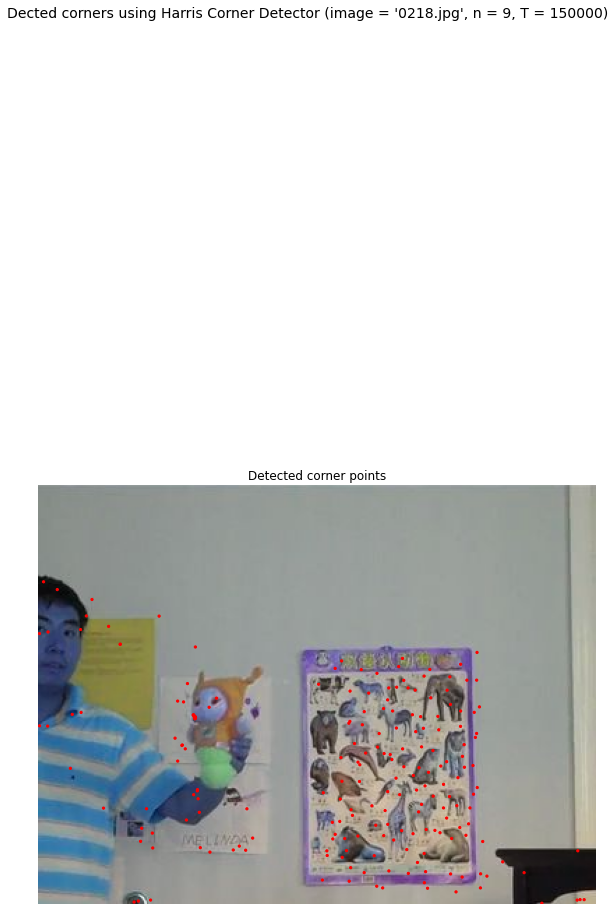

19  =  0218.jpg
175
4
171 : 180
[[  0.   0.   0.   0.  75.  80.  83.  79.  72.]
 [  0.   0.   0.   0.  75.  83.  82.  72.  72.]
 [  0.   0.   0.   0.  81.  69.  71.  93. 115.]
 [  0.   0.   0.   0.  71.  75.  92. 115. 124.]
 [  0.   0.   0.   0.  74. 101. 122. 119. 110.]
 [  0.   0.   0.   0. 107. 117. 121. 116. 116.]
 [  0.   0.   0.   0. 127. 115. 110. 116. 118.]
 [  0.   0.   0.   0. 123. 116. 113. 115. 111.]
 [  0.   0.   0.   0. 120. 122. 118. 110. 114.]]
x =  0.7477271249984377 , y =  171.904562913684
vx =  -0.0017486226981241883 , vy =  0.08719432217266745
x_new =  0.7302408980171958 , y_new =  172.77650613541067


72
7
68 : 77
[[  0. 117. 135. 152. 147. 124. 112. 130. 156.]
 [  0.  46.  74.  96.  83.  49.  38.  72. 114.]
 [  0.  11.  23.  31.  26.  12.  11.  33.  58.]
 [  0.  16.  11.   9.  14.  23.  28.  27.  25.]
 [  0.  13.  16.  19.  20.  21.  22.  21.  20.]
 [  0.  15.  19.  21.  17.  13.  14.  17.  18.]
 [  0.  20.  19.  15.  11.  14.  19.  18.  13.]
 [  0.   9.  15.  17.

x_new =  222.11126405034526 , y_new =  146.96487951703472


287
226
283 : 292
[[137. 139. 147. 144. 138. 140. 139. 138. 133.]
 [122. 126. 130. 127. 125. 126. 134. 126. 121.]
 [123. 125. 126. 121. 116. 115. 131. 119. 108.]
 [130. 130. 128. 122. 114. 111. 137. 123. 109.]
 [137. 137. 135. 129. 121. 116. 124. 117. 112.]
 [171. 170. 167. 162. 155. 150. 145. 142. 140.]
 [164. 161. 158. 155. 150. 145. 151. 146. 143.]
 [128. 124. 122. 123. 122. 119. 124. 123. 124.]
 [156. 153. 154. 159. 161. 160. 161. 160. 160.]]
x =  222.69435680838478 , y =  283.2985280025275
vx =  -0.085068145627447 , vy =  0.09961287306227666
x_new =  221.84367535211032 , y_new =  284.2946567331503


135
235
131 : 140
[[124. 130.  92. 105. 130. 116. 162. 141. 130.]
 [134. 130.  88. 115. 120. 128. 150. 146. 117.]
 [134. 144.  89. 119. 124. 109. 123. 123. 114.]
 [135. 163. 103. 128. 126. 106. 120. 125. 113.]
 [130. 153. 112. 125. 121. 137. 134. 135. 141.]
 [112. 107.  98. 100. 101.  99.  88.  86.  98.]
 [131. 115. 123. 116. 

x_new =  280.4494961059527 , y_new =  152.80272536437909


209
283
205 : 214
[[ 97. 101. 117. 130. 126. 157. 168. 167. 158.]
 [118. 107. 119. 136. 127. 149. 163. 155. 133.]
 [125. 117. 120. 134. 141. 143. 151. 135. 107.]
 [117. 119. 107. 109. 139. 159. 145. 113.  90.]
 [111. 115.  92.  82. 120. 153. 124.  83.  71.]
 [108. 105.  85.  77. 101. 120. 106.  74.  62.]
 [102.  94.  83.  82.  89. 102. 112.  94.  72.]
 [103. 112. 114.  82.  80. 107. 117. 135.  85.]
 [109. 103. 108.  88.  86. 109. 109. 131.  79.]]
x =  279.5816763925596 , y =  205.22854708968174
vx =  -0.035892882655414814 , vy =  0.05869657128927331
x_new =  279.22274756600547 , y_new =  205.81551280257446


250
281
246 : 255
[[166. 172. 171. 155.  81. 110. 136. 172. 181.]
 [165. 171. 169. 164.  94. 116. 157. 177. 175.]
 [168. 170. 169. 168. 101. 120. 156. 178. 177.]
 [172. 170. 170. 166.  99. 117. 126. 183. 184.]
 [176. 167. 169. 160.  97. 122. 100. 176. 183.]
 [179. 162. 165. 155.  99. 135.  95. 156. 175.]
 [181. 165. 169. 15

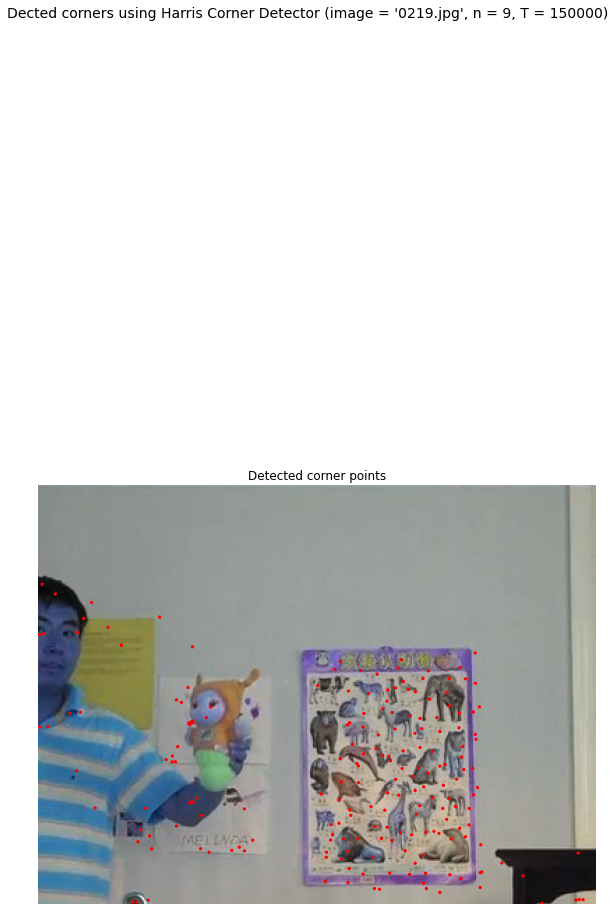

20  =  0219.jpg
176
4
172 : 181
[[  0.   0.   0.   0.  74.  82.  81.  71.  71.]
 [  0.   0.   0.   0.  87.  73.  70.  88. 109.]
 [  0.   0.   0.   0.  73.  75.  90. 112. 122.]
 [  0.   0.   0.   0.  67.  96. 121. 122. 114.]
 [  0.   0.   0.   0. 101. 114. 120. 117. 116.]
 [  0.   0.   0.   0. 128. 116. 110. 115. 117.]
 [  0.   0.   0.   0. 124. 116. 113. 115. 111.]
 [  0.   0.   0.   0. 118. 121. 118. 110. 113.]
 [  0.   0.   0.   0. 111. 114. 120. 127. 133.]]
x =  0.7302408980171958 , y =  172.77650613541067
vx =  0.0011997445764679398 , vy =  -0.022912776101844636
x_new =  0.7422383437818753 , y_new =  172.54737837439222


74
6
70 : 79
[[ 0.  0. 23. 40. 46. 31. 15. 23. 50.]
 [ 0.  0.  9. 13. 17. 20. 25. 29. 26.]
 [ 0.  0. 18. 21. 22. 21. 22. 24. 25.]
 [ 0.  0. 17. 16. 14. 11. 11. 14. 19.]
 [ 0.  0. 19. 15. 13. 16. 20. 22. 18.]
 [ 0.  0. 13. 15. 17. 17. 14. 12. 13.]
 [ 0.  0. 12. 12. 12. 13. 13. 13. 13.]
 [ 0.  0. 10. 10. 10. 10. 10. 11. 11.]
 [ 0.  0.  9.  9.  9.  9.  9. 10. 10.]]
x 

x_new =  108.64299519380353 , y_new =  175.7823959727698


227
117
223 : 232
[[69. 70. 71. 71. 70. 73. 77. 76. 71.]
 [70. 71. 72. 75. 74. 74. 75. 74. 71.]
 [71. 71. 72. 78. 76. 75. 74. 73. 72.]
 [72. 72. 73. 76. 75. 75. 74. 74. 74.]
 [73. 73. 73. 73. 74. 74. 74. 75. 75.]
 [72. 72. 72. 72. 72. 71. 71. 71. 71.]
 [72. 72. 72. 72. 72. 71. 71. 71. 71.]
 [72. 72. 72. 72. 72. 71. 71. 71. 71.]
 [72. 72. 72. 72. 72. 71. 71. 71. 71.]]
x =  113.42828239856792 , y =  223.58752484785185
vx =  -0.11795792762204074 , vy =  0.1132250189409883
x_new =  112.24870312234751 , y_new =  224.71977503726174


201
99
197 : 206
[[150. 151. 152. 152. 151. 157. 158. 158. 159.]
 [152. 154. 156. 159. 161. 156. 156. 156. 156.]
 [152. 153. 154. 158. 162. 158. 158. 158. 158.]
 [151. 150. 148. 150. 153. 153. 153. 153. 153.]
 [154. 154. 152. 154. 157. 153. 153. 153. 153.]
 [152. 151. 149. 151. 154. 155. 155. 154. 154.]
 [145. 138. 132. 131. 132. 131. 130. 129. 128.]
 [150. 148. 143. 139. 137. 145. 142. 142. 144.]
 [151.

x =  251.79630590639871 , y =  277.52029918422346
vx =  -0.05364345770211461 , vy =  -0.031261240861479814
x_new =  251.25987132937757 , y_new =  277.20768677560864


225
262
221 : 230
[[195. 174. 182. 160. 167. 165. 149.  86.  80.]
 [182. 164. 187. 173. 192. 179. 142.  96.  93.]
 [170. 175. 152. 176. 177. 164. 126. 104. 115.]
 [158. 168. 175. 167. 165. 173. 133. 105. 116.]
 [118. 152. 170. 126. 149. 151. 102.  86.  83.]
 [125. 164. 149. 136. 172. 163. 108. 100.  90.]
 [175. 173. 165. 174. 167. 155.  98.  87. 108.]
 [163. 150. 165. 153. 170. 136.  86. 113.  78.]
 [174. 173. 173. 179. 173. 115. 100. 113.  85.]]
x =  258.33430929807395 , y =  221.6727795026376
vx =  -0.06378828285057256 , vy =  -0.14924307159032707
x_new =  257.6964264695682 , y_new =  220.18034878673433


144
265
140 : 149
[[182. 168. 161. 169. 169. 166. 171. 163. 169.]
 [162. 137. 109. 111. 155. 180. 159. 170. 164.]
 [151. 135.  89.  68. 127. 180. 157. 165. 167.]
 [157. 149.  91.  54.  91. 156. 169. 160. 172.]
 [167. 1

vx =  -0.0836360231034618 , vy =  0.05461187520334434
x_new =  312.20968418581407 , y_new =  120.1997267133001


261
321
257 : 266
[[141. 166. 162. 161. 164. 163. 162. 163. 163.]
 [142. 167. 162. 160. 163. 163. 163. 163. 163.]
 [143. 167. 162. 159. 163. 163. 164. 163. 163.]
 [133. 172. 162. 165. 162. 163. 163. 162. 167.]
 [133. 171. 162. 164. 162. 163. 163. 161. 163.]
 [133. 171. 161. 163. 161. 163. 164. 163. 160.]
 [132. 170. 160. 163. 161. 164. 164. 167. 163.]
 [131. 170. 160. 163. 161. 163. 164. 165. 164.]
 [130. 170. 161. 164. 162. 163. 163. 160. 163.]]
x =  317.06400258635165 , y =  257.2027231093198
vx =  -0.05001919158295394 , vy =  0.038459821465660904
x_new =  316.5638106705221 , y_new =  257.58732132397637


280
321
276 : 285
[[129. 171. 161. 161. 169. 166. 158. 160. 160.]
 [134. 171. 161. 159. 164. 162. 157. 160. 160.]
 [134. 167. 160. 158. 159. 158. 159. 159. 159.]
 [125. 159. 159. 160. 158. 157. 162. 159. 159.]
 [114. 154. 159. 162. 158. 156. 161. 159. 159.]
 [106. 153. 16

IndexError: arrays used as indices must be of integer (or boolean) type

In [11]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import math

# Read in image and return the original and gray scale version of it
def read_img(folder, img):
    """
        folder: relative folder path
        img:    image name
    """
    try:
        image = cv2.imread(folder + '/' + img) 
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        image_gray = image_gray.astype(np.float32)
    except:
        print(f"Something went wrong reading the {img} image")
        exit()

    return image, image_gray

# Add horizontal and vertical padding to a given image I
def add_padding(I, padding):
    # Add vertical padding
    row = np.zeros((padding, I.shape[1]))
    I = np.vstack((row, I, row))

    # Add horizontal padding
    col = np.zeros((I.shape[0], padding))
    I = np.hstack((col, I, col))
    return I

# Round half number properly up
def normal_round(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

# Tracks all corners given the indices in the initial frame by computing optimal flow for these points
def track_features(H, n, c, r, folder):
    """
        H:      see harris corner detector for definition
        n:      neigbourhood window size n x n
        c:      column indices of corner points
        r:      row indices of corner points
        folder: relative folder path
    """

    # Read in all image names
    images = sorted(os.listdir(folder))

    # Neighbors size surrounding centered pixel
    padding = n // 2

    i = 1

    # Dimension of image        
    y_max, x_max = H.shape
    print(y_max)

    # Loop through all images, i.e. frames, in sequential order
    while i < len(images):
        name_current = images[i - 1]
        name_next = images[i]

        print(i, " = ", name_current)

        # Current frame
        img_current, img_current_gray = read_img(folder, name_current)
        # Add zeroes padding to be able to process border pixels
        img_current_padded = add_padding(img_current_gray, padding)

        # Next frame
        img_next, img_next_gray = read_img(folder, name_next)
        # Add zeros padding to be able to process border pixels
        img_next_padded = add_padding(img_next_gray, padding)

        corner_i  = 0

        # When next location of corner point leads to out of bounds when computing it is saved in this list to remove it 
        # DOES NOT WORK?   
        corners_to_remove = np.empty(0)

        # Get corner detected points in current image and track how they will move in the next frame according to vx and vy
        for corner_i in range(len(r)):

            # Corner detected point
            corner_center_r = int(r[corner_i]) + padding
            corner_center_c = int(c[corner_i]) + padding

            print(corner_center_r)
            print(corner_center_c)

            # Indices to slice neighborhood of corner point
            r_start = corner_center_r - padding
            r_end = corner_center_r + padding + 1
            c_start = corner_center_c - padding
            c_end = corner_center_c + padding + 1

            print(r_start, ":", r_end)

            if (corner_center_r < 0) or (corner_center_r >= y_max + padding - 1) or (corner_center_c < 0) or (corner_center_c >= x_max + padding - 1):
                print("Out of bounds")                
            else:
                # Get neighbourhood of corner point in current frame 
                img_current_patch = img_current_padded[r_start:r_end, c_start:c_end]
                print(img_current_patch)

                # Get neigbourhood  of corner point in next frame
                img_next_patch = img_next_padded[r_start:r_end, c_start:c_end]
                
                # Get scalars in x and y direction
                v = estimate_optical_flow(img_current_patch, img_next_patch, n)
                vx = v[0]
                vy = v[1]
                print("x = ", c[corner_i] , ", y = ", r[corner_i])
                print("vx = ", vx[0], ", vy = ", vy[0])

                # Compute shifted indices since we assume/use unit vectors we can just add vy and vx
                new_r_i = r[corner_i] + 10*vy
                new_c_i = c[corner_i] + 10*vx

                # If shift of corner results into out of bounds remove corner from being used in next frame, e.g. when a corner gets out of the view 
                # DOES NOT WORK?
                if (new_r_i < 0) or (new_r_i >= y_max + padding - 1) or (new_c_i < 0) or (new_c_i >= x_max + padding - 1):
                    print("Corner out of view: ", new_r_i, ', ', new_c_i)
                    # Save indices to remove
                    corners_to_remove = np.append(corners_to_remove, corner_i)
                else:
                    r[corner_i] = new_r_i
                    c[corner_i] = new_c_i
                    print("x_new = ", c[corner_i] , ", y_new = ", r[corner_i])
                
                print("\n")

        print(corners_to_remove)

        # DOES NOT WORK?
        if len(corners_to_remove != 0):
            c = np.delete(c, corners_to_remove)
            r = np.delete(r, corners_to_remove)

        # After shifting al indices of corner points show new locations    
        show_corners(img_next, c, r, name_next)
        plt.show()

        i += 1

    return

def show_corners(I, c, r, img):
    fig, (ax_corners) = plt.subplots(1, 1, figsize=(10, 20))
    
    # Original image with detected corner point
    ax_corners.imshow(I, cmap='gray')
    ax_corners.scatter(c, r, s=np.full(c.size, 5), color='red')
    ax_corners.set_title(r'Detected corner points')
    ax_corners.set_axis_off()

    fig.suptitle(f"Dected corners using Harris Corner Detector (image = '{img}', n = {n}, T = {T})", fontsize=14)

if __name__ == "__main__":
    n = 9
    T = 150000
    img = '/doll/0200.jpg'

    # Read in images
    try:
        image = cv2.imread('./lab3/images' + img) #'./images/test_corner.png')
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        image_gray = image_gray.astype(np.float32)
    except:
        print(f"Something went wrong reading the {img} image")
        exit()
    
    # Kernels to compute gradients along x- and y-axis
    G_x = np.array([[-1, 0, 1]]) # Central difference
    G_y = G_x.T

    # Compute gradient in x-direction
    I_x = compute_partial_derivative(image_gray, G_x)
    # Compute gradient in y-direction
    I_y = compute_partial_derivative(image_gray, G_y)

    A, B, C = compute_Q_components(I_x, I_y)
    H = compute_H(A, B, C)
    r, c = detect_corners(H, n, T)

    # Show initial image where corner points were detected
    show_corners(image, c, r, img)
    plt.show()
        
    track_features(H, n, c, r, './lab3/images/doll')